In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import math
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

In [2]:
data1 = pd.read_csv("party1.csv", index_col=0)
data2 = pd.read_csv("party.csv",index_col=0)
songs = pd.read_csv("songs.csv")
songs_people = pd.read_csv("songs_people.csv")

In [3]:
data = data1.append(data2, ignore_index=True)

In [4]:
data["timestamp"] = pd.to_datetime(data["timestamp"])

In [5]:
data.head()

,timestamp,temperature,humidity,eCO2,TVOC,inf0,inf1,inf2,inf3,inf4,...,inf54,inf55,inf56,inf57,inf58,inf59,inf60,inf61,inf62,inf63
0,2022-05-05 15:26:24.766186,26.2,43.0,400.0,0.0,25.50,25.00,25.00,25.25,25.25,...,27.50,27.50,29.75,29.75,29.00,26.50,26.75,27.00,27.25,27.50
1,2022-05-05 15:26:30.821025,26.2,43.3,400.0,0.0,32.50,33.00,33.00,33.00,31.25,...,27.75,27.75,30.75,30.00,28.50,26.50,27.50,27.50,27.25,28.00
2,2022-05-05 16:17:35.288253,26.0,43.2,400.0,0.0,25.25,25.00,25.50,28.50,30.50,...,28.00,28.75,30.25,30.25,29.25,27.00,27.75,28.25,28.25,28.75
3,2022-05-05 16:17:46.011081,26.3,42.9,400.0,0.0,25.25,24.75,25.50,28.50,30.25,...,27.75,28.50,29.50,29.50,29.00,26.25,27.50,27.75,27.75,28.75
4,2022-05-05 16:18:59.590735,26.3,42.9,400.0,0.0,25.50,25.75,24.75,25.25,25.75,...,28.00,28.25,30.00,29.75,29.00,26.25,27.25,27.25,28.00,28.75


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7278 entries, 0 to 7277
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    7278 non-null   datetime64[ns]
 1   temperature  6989 non-null   float64       
 2   humidity     6989 non-null   float64       
 3   eCO2         7252 non-null   float64       
 4   TVOC         7252 non-null   float64       
 5   inf0         7252 non-null   float64       
 6   inf1         7252 non-null   float64       
 7   inf2         7252 non-null   float64       
 8   inf3         7252 non-null   float64       
 9   inf4         7252 non-null   float64       
 10  inf5         7252 non-null   float64       
 11  inf6         7252 non-null   float64       
 12  inf7         7252 non-null   float64       
 13  inf8         7252 non-null   float64       
 14  inf9         7252 non-null   float64       
 15  inf10        7252 non-null   float64       
 16  inf11 

Cleaning faulty timestamps caused by sensor shutdowns

In [7]:
time_errors = data[data["timestamp"].diff() < pd.Timedelta("0")].index
time_errors

Int64Index([114, 314, 335, 345, 383, 1671, 2253, 2858, 3764, 4003, 4045, 4163,
            7236],
           dtype='int64')

In [8]:
data.loc[time_errors[0], "timestamp"] = pd.to_datetime('2022-05-09 17:33:00')
data.loc[time_errors[0]+1, "timestamp"] = pd.to_datetime('2022-05-09 17:34:00')

In [9]:
for i in range(10):
    data.loc[314+i, "timestamp"] = pd.to_datetime('2022-05-11 10:{}:00'.format(30+i))

In [10]:
for i in range(8):
    temp = data.loc[314+i].copy()
    data.loc[314+i] = data.loc[324+i]
    data.loc[324+i] = temp

In [11]:
for i in range(4):
    temp1 = data.loc[322+2*i].copy()
    temp2 = data.loc[323+2*i].copy()
    data.loc[322+2*i] = data.loc[324+2*i]
    data.loc[323+2*i] = data.loc[325+2*i]
    data.loc[324+2*i] = temp1
    data.loc[325+2*i] = temp2

In [12]:
data.loc[335, "timestamp"] = pd.to_datetime('2022-05-11 10:44:24')

In [13]:
for i in range(3):
    data.loc[343+i, "timestamp"] = pd.to_datetime("2022-05-23 15:{}:00".format(45+i))

In [14]:
data.loc[383, "timestamp"] = pd.to_datetime('2022-05-24 15:09:00')

In [15]:
data.loc[1671, "timestamp"] = pd.to_datetime('2022-05-25 12:56:00')

In [16]:
data.loc[2253, "timestamp"] = pd.to_datetime('2022-06-11 23:31:00')

In [17]:
for i in range(81):
    h = 19 + math.floor((i+25)/60)
    m = (i+25)%60
    data.loc[2858+i, "timestamp"] = pd.to_datetime("2022-06-16 {}:{}:00".format(h, m))

In [18]:
data.loc[3764, "timestamp"] = pd.to_datetime("2022-06-18 15:40:00")

In [19]:
for i in range(197):
    h = math.floor((i+47)/60)
    m = (i+47)%60
    data.loc[4003+i, "timestamp"] = pd.to_datetime("2022-06-19 {}:{}:00".format(h, m))

In [20]:
for i in range(5):
    data.loc[time_errors[12]+i, "timestamp"] = pd.to_datetime("2022-07-30 21:{}:00".format(9+i))

Investigating large gaps in time between datapoints

In [21]:
time_skips = data[data["timestamp"].diff() > pd.Timedelta("01:00:00")].index
time_skips

Int64Index([  17,   88,  114,  322,  343,  377, 1687, 1688, 2112, 2858, 3764,
            3793, 4200, 4206, 4208, 4440, 4791, 7236, 7241],
           dtype='int64')

In [22]:
skip_errors = [2, 5,10, 11, 14, 27, 18]

In [23]:
data.loc[114, "timestamp"] = pd.to_datetime("2022-05-07 11:25:41")

In [24]:
for i, idx in enumerate([375,376]):
    data.loc[idx, "timestamp"] = pd.to_datetime("2022-05-24 14:5{}:24".format(i+3))

In [25]:
for i in range(2):
    data.loc[4206+i, "timestamp"] = pd.to_datetime("2022-07-23 21:15:{}3".format(1+i))

In [26]:
for i in range(4):
    data.loc[2108+i, "timestamp"] = pd.to_datetime("2022-06-11 21:0{}:46".format(3+i))

In [27]:
data.iloc[314:322, 1:] = np.nan

In [28]:
assert (data["timestamp"].diff()[1:] >= pd.Timedelta("0")).all()

Cleaning erroneous values

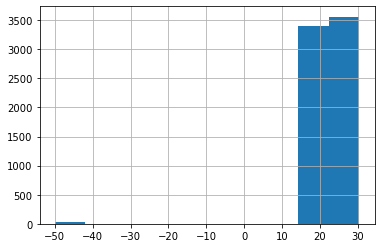

In [29]:
data["temperature"].hist();

In [30]:
data[data["temperature"] < 10]["temperature"].unique()

array([-50.])

In [31]:
data.loc[data["temperature"] == -50, "temperature"] = np.nan

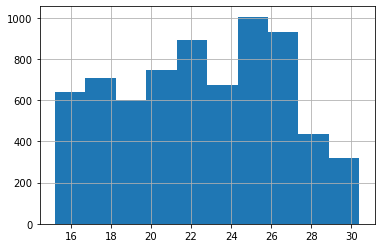

In [32]:
data["temperature"].hist();

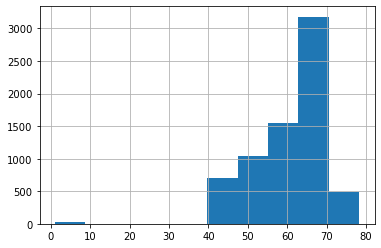

In [33]:
data["humidity"].hist();

In [34]:
data[data["humidity"] < 30]["humidity"].unique()

array([1.])

In [35]:
data.loc[data["humidity"] == 1, "humidity"] = np.nan

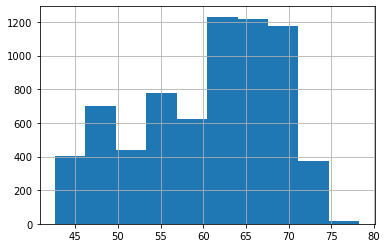

In [36]:
data["humidity"].hist();

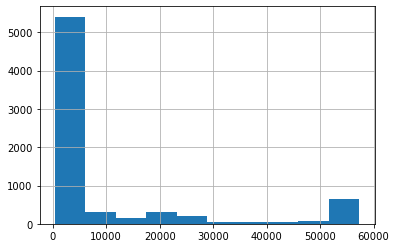

In [37]:
data["eCO2"].hist();

Defining columns used for statistics

In [38]:
data["inf_mean"] = data.loc[:,data.columns[5:69]].mean(axis=1)
data["timestamp_diff"] = data["timestamp"].diff()
data["inf_mean_diff"] = data["inf_mean"].diff()
data["humidity_diff"] = data["humidity"].diff()
data["TVOC_diff"] = data["TVOC"].diff()
data["eCO2_diff"] = data["eCO2"].diff()
data["temp_diff"] = data["temperature"].diff()
data["humidity_diff_shift"] = data["humidity_diff"].shift(-1)

In [39]:
trans_day = data[data["timestamp"].diff() > pd.Timedelta("00:01:02")].index
len(trans_day)

50

In [40]:
data.loc[trans_day, "inf_mean_diff"] = np.nan

In [41]:
data["date"] = data["timestamp"].apply(lambda x: x.floor("d"))
data["hour"] = data["timestamp"].apply(lambda x: x.hour)
data["hour_date"] = data["timestamp"].apply(lambda x: x.floor("h"))

Cleaning song data

In [42]:
songs.head()

,timestamp,song
0,07.05.2022 21:44:54,Da Tweekaz - How Far I'll Go
1,07.05.2022 21:47:51,Tream - FEEL LIKE
2,07.05.2022 21:50:18,Bangbros - Children - Sunset Project Remix Rad...
3,07.05.2022 21:52:50,LMFAO - Party Rock Anthem
4,07.05.2022 21:57:01,Die Prinzen - Alles nur geklaut


In [43]:
songs["timestamp"] = pd.to_datetime(songs["timestamp"], dayfirst=True)
songs.dtypes

timestamp    datetime64[ns]
song                 object
dtype: object

In [44]:
songs_people.sample(10)

,timestamp,song,people
12,29.07.2022 22:58:18,Discotronic - Tricky Disco - Single Edit,11.0
17,29.07.2022 23:12:41,Aqua - Barbie Girl,11.0
52,30.07.2022 00:54:09,Jumpstarz - Umbrella,9.0
41,30.07.2022 00:22:47,2 Engel & Charlie - Goethe - Harris & Ford Edit,15.0
20,29.07.2022 23:21:51,CRO - Einmal um die Welt,10.0
62,30.07.2022 01:21:50,Royal Republic - Full Steam Spacemachine,7.0
31,29.07.2022 23:53:25,"T»MA a.k.a. Falco - Mutter, der Mann mit dem K...",11.0
22,29.07.2022 23:27:44,DJ Alex Kea - Rama lama ding dong - Topless Re...,5.0
65,30.07.2022 01:30:36,Taio Cruz - Higher,10.0
21,29.07.2022 23:24:03,Alligatoah - Fick ihn doch,7.0


In [45]:
songs_people["timestamp"] = pd.to_datetime(songs_people["timestamp"], dayfirst=True)
songs_people.dtypes

timestamp    datetime64[ns]
song                 object
people              float64
dtype: object

In [46]:
songs = songs.merge(songs_people.drop("song", axis=1), on="timestamp", how="left")

In [47]:
songs.head()

,timestamp,song,people
0,2022-05-07 21:44:54,Da Tweekaz - How Far I'll Go,NaN
1,2022-05-07 21:47:51,Tream - FEEL LIKE,NaN
2,2022-05-07 21:50:18,Bangbros - Children - Sunset Project Remix Rad...,NaN
3,2022-05-07 21:52:50,LMFAO - Party Rock Anthem,NaN
4,2022-05-07 21:57:01,Die Prinzen - Alles nur geklaut,NaN


In [48]:
songs.groupby("song").count().sort_values("timestamp", ascending=False).head(10)

,timestamp,people
song,,
Drag,76,0
Tream - LEBENSLANG - HBz Remix,16,0
Julian Sommer - Dicht im Flieger,11,1
Los Bressackos - Dosawoiza,11,0
Die Pagger Buam - Ein Abend auf der Heidi,10,0
Little Sis Nora - MDMA,9,1
DJ Robin - Layla,9,2
FiNCH - Herzalarm,9,0
Stefan Rauch - Dosenbier,8,0


In [49]:
# 'Drag' is not a song but a bug in the script, probably caused when Spotify is loading new songs
songs = songs[songs["song"] != 'Drag']

In [50]:
songs["end"] = songs["timestamp"].shift(-1)
songs["length"] = songs["end"] - songs["timestamp"]

In [51]:
songs.head(2)

,timestamp,song,people,end,length
0,2022-05-07 21:44:54,Da Tweekaz - How Far I'll Go,NaN,2022-05-07 21:47:51,0 days 00:02:57
1,2022-05-07 21:47:51,Tream - FEEL LIKE,NaN,2022-05-07 21:50:18,0 days 00:02:27


In [52]:
songs.sort_values("length", ascending=False).head(20)
# Length > 1 day are just the time between partys, length > 10 minutes indicate missing date, e.g. the script stopped working

,timestamp,song,people,end,length
842,2022-06-19 13:20:51,Skrillex - Bangarang (feat. Sirah),NaN,2022-07-15 22:03:52,26 days 08:43:01
160,2022-05-08 04:05:40,"Haddaway - What Is Love - 7"" Mix",NaN,2022-05-27 21:23:13,19 days 17:17:33
230,2022-05-28 02:27:20,Peter Schilling - Major Tom (Völlig losgelöst)...,NaN,2022-06-11 21:05:03,14 days 18:37:43
956,2022-07-16 03:22:25,NaN,NaN,2022-07-29 22:21:06,13 days 18:58:41
581,2022-06-12 12:08:06,The Connells - '74-'75,NaN,2022-06-18 22:19:03,6 days 10:10:57
580,2022-06-12 09:58:37,Sophie B. Hawkins - Right Beside You,NaN,2022-06-12 12:08:06,0 days 02:09:29
840,2022-06-19 11:25:26,Fäaschtbänkler - Can You English Please,NaN,2022-06-19 13:19:15,0 days 01:53:49
171,2022-05-27 21:51:22,"David Guetta - Hey Mama (feat. Nicki Minaj, Be...",NaN,2022-05-27 23:20:07,0 days 01:28:45
232,2022-06-11 21:06:11,Spin Doctors - Two Princes,NaN,2022-06-11 22:32:02,0 days 01:25:51
118,2022-05-08 02:17:19,R.I.O. - Megamix,NaN,2022-05-08 02:25:23,0 days 00:08:04


In [53]:
#All lengths above 10 minutes are faulty
songs.loc[(songs["length"] > pd.Timedelta("00:10:00")) | (songs["length"] < pd.Timedelta("00:00:00")), "length"] = np.nan

In [54]:
# We could fetch the song duration from the Spotify API, however this is not reliable as the song could have been skipped halfway.
# In fact precisely the fact that this data is faulty indicates that the laptop might have crashed
# We will just assume the song to have average length
avg_length = songs["length"].mean().floor('S')
avg_length

Timedelta('0 days 00:02:43')

In [55]:
songs.loc[songs["length"].isna(), "length"] = avg_length

In [56]:
songs.rename({"timestamp": "start"}, axis=1, inplace=True)

In [57]:
songs[songs["end"].isna()]

,start,song,people,end,length
1119,2022-07-30 05:28:29,Hammerer - Gianny For Example,NaN,NaT,0 days 00:02:43


In [58]:
songs["end"] = songs["start"] + songs["length"]

In [59]:
songs.reset_index(drop=True, inplace=True)

In [60]:
songs.head()

,start,song,people,end,length
0,2022-05-07 21:44:54,Da Tweekaz - How Far I'll Go,NaN,2022-05-07 21:47:51,0 days 00:02:57
1,2022-05-07 21:47:51,Tream - FEEL LIKE,NaN,2022-05-07 21:50:18,0 days 00:02:27
2,2022-05-07 21:50:18,Bangbros - Children - Sunset Project Remix Rad...,NaN,2022-05-07 21:52:50,0 days 00:02:32
3,2022-05-07 21:52:50,LMFAO - Party Rock Anthem,NaN,2022-05-07 21:57:01,0 days 00:04:11
4,2022-05-07 21:57:01,Die Prinzen - Alles nur geklaut,NaN,2022-05-07 22:00:03,0 days 00:03:02


Merging song data and sensor data

In [61]:
for song in songs.values:
    # song: ["start", "song_name", "num_people", "end", "length"]
    index = np.where((data["timestamp"] >= song[0]) & (data["timestamp"] < song[3]))
    for i in index:
        data.loc[i, "song"] = song[1]
        data.loc[i, "num_people"] = song[2]

In [62]:
data["tdiff"] = data["temperature"].diff()
data.loc[trans_day, "tdiff"] = np.nan

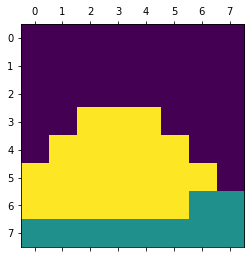

In [63]:
limits = np.zeros((8,8))
limits[6:8] = 0.5
limits[6, 0:6] = 1
limits[5, 0:7] = 1
limits[4, 1:6] = 1
limits[3, 2:5] = 1
plt.matshow(limits);

In [64]:
# x=7-6: standing behind bar
# x=6-5: standing at bar
# x=4: standing in the middle of the room
# x=4-3: standing at the back of the room

In [65]:
floor_pixels = list()
for x in range(8):
    for y in range(8):
        if limits[x,y] > 0:
            floor_pixels.append("inf{}".format(y+x*8))

In [66]:
ceiling_pixels = data.columns[5:69]
ceiling_pixels = ceiling_pixels.drop(floor_pixels)
ceiling_pixels

Index(['inf0', 'inf1', 'inf2', 'inf3', 'inf4', 'inf5', 'inf6', 'inf7', 'inf8',
       'inf9', 'inf10', 'inf11', 'inf12', 'inf13', 'inf14', 'inf15', 'inf16',
       'inf17', 'inf18', 'inf19', 'inf20', 'inf21', 'inf22', 'inf23', 'inf24',
       'inf25', 'inf29', 'inf30', 'inf31', 'inf32', 'inf38', 'inf39', 'inf47'],
      dtype='object')

In [67]:
data["minute"] = data["timestamp"].apply(lambda x: x.floor('T'))
songs["date"] = songs["start"].apply(lambda x: x.floor("D"))
data["inf_std"] = data.iloc[:, 5:69].std(axis=1)
data["inf_std_floor"] = data.loc[:, floor_pixels].std(axis=1)

Building models to predict crowd size

In [68]:
data_inf = data[data["inf0"].notna()]

In [69]:
# This is the data of test 3
data.loc[4440:4790, "num_people"] = 0
data.loc[(data["timestamp"] >= '2022-07-29 17:40:09') & (data["timestamp"] <='2022-07-29 17:41:59'), "num_people"] = 1
data.loc[(data["timestamp"] >= '2022-07-29 17:48:50') & (data["timestamp"] <='2022-07-29 17:50:00'), "num_people"] = 1
data.loc[(data["timestamp"] >= '2022-07-29 17:51:53') & (data["timestamp"] <='2022-07-29 17:53:00'), "num_people"] = 1

In [70]:
party_people = data[data["num_people"].notna()]

In [71]:
party_people["inf_std"].corr(party_people["num_people"])

0.8591763515319768

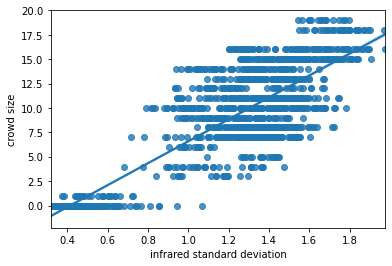

In [72]:
sns.regplot(x=party_people["inf_std"], y=party_people["num_people"])
plt.ylabel("crowd size")
plt.xlabel("infrared standard deviation");

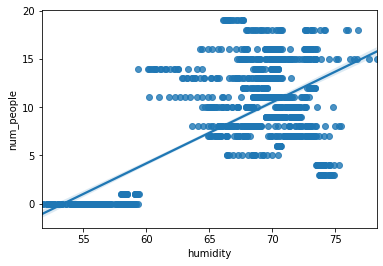

In [73]:
sns.regplot(x=party_people["humidity"], y=party_people["num_people"]);

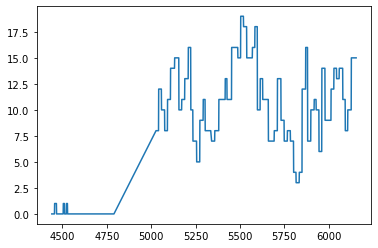

In [74]:
plt.plot(party_people["num_people"]);

In [75]:
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(party_people["inf_std"].values.reshape(-1,1), party_people["num_people"].values, test_size=0.2)
X_train_std_floor, X_test_std_floor, y_train_std_floor, y_test_std_floor = train_test_split(party_people["inf_std_floor"].values.reshape(-1,1), party_people["num_people"].values, test_size=0.2)
X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(party_people[party_people["humidity"].notna()]["humidity"].values.reshape(-1,1), party_people[party_people["humidity"].notna()]["num_people"].values, test_size=0.2)

In [76]:
reg_mod_std = LinearRegression().fit(X_train_std, y_train_std)
reg_mod_std_floor = LinearRegression().fit(X_train_std_floor, y_train_std_floor)
reg_mod_hum = LinearRegression().fit(X_train_hum, y_train_hum)

In [77]:
tree_mod = DecisionTreeRegressor()
forest_mod = RandomForestRegressor()
ada_mod = AdaBoostRegressor()
reg_mod = LinearRegression()

In [78]:
party_people.count().max()

1475

In [79]:
X_train, X_test, y_train, y_test = train_test_split(party_people.iloc[:,5:69], party_people["num_people"], test_size = 0.2)
X_test, X_cross, y_test, y_cross = train_test_split(X_test, y_test, test_size=0.5)

In [80]:
tree_mod.fit(X_train, y_train)
forest_mod.fit(X_train, y_train)
ada_mod.fit(X_train, y_train)
reg_mod.fit(X_train, y_train);

In [81]:
from sklearn.metrics import r2_score
labels = ["decision tree", "random forest", "AdaBoost", "Linear regression"]
models = [tree_mod, forest_mod, ada_mod, reg_mod]
for label, mod in zip(labels, models):
    pred = mod.predict(X_cross)
    print(label, mean_squared_error(y_cross, pred), r2_score(y_cross, pred))

decision tree 8.29054054054054 0.7387239491536397
random forest 3.84044527027027 0.8789685221607545
AdaBoost 9.14880164088872 0.7116758851827224
Linear regression 5.498443808327904 0.8267167650872052


In [82]:
print(mean_squared_error(y_test_std, reg_mod_std.predict(X_test_std)))
print(mean_squared_error(y_test_std_floor, reg_mod_std_floor.predict(X_test_std_floor)))
print(mean_squared_error(y_test_hum, reg_mod_hum.predict(X_test_hum)))

6.92794634363001
8.748221576642448
12.642178691877042


Model to predict ventilation activity

In [83]:
ven = 0
pred_ven = list()
for i in range(data.shape[0]):
    idx = data.index[i]
    time_diff = data["timestamp"].diff().loc[idx]
    if pd.isnull(time_diff) or time_diff > pd.Timedelta("01:00:00"):
        ven = 0
    elif data.loc[idx]["inf_mean_diff"] < -1.28 and (data.loc[idx:idx+4]["humidity_diff"] <= -1.19).any():
        ven = 1
    elif data.loc[idx]["inf_mean_diff"] > 0.77 and (data.loc[idx:idx+5]["humidity_diff"] >= 0.2).any():
        ven = 0
    pred_ven.append(ven)
data["ventilation_pred"] = pred_ven

In [84]:
# Crowd size model predictions
data["num_people_pred_std"] = data_inf["inf_std"].apply(lambda x: math.floor(reg_mod_std.predict([[x]])[0]))
data["num_people_pred"] = data_inf.iloc[:,5:69].apply(lambda x: math.floor(reg_mod.predict(x.values.reshape(1,-1))[0]), axis=1)
data["num_people_pred_rf"] = data_inf.iloc[:,5:69].apply(lambda x: tree_mod.predict(x.values.reshape(1,-1))[0], axis=1)
data["num_people_pred_std_floor"] = data_inf["inf_std_floor"].apply(lambda x: math.floor(reg_mod_std_floor.predict([[x]])[0]))
data["num_people_pred_hum"] = data[data["humidity"].notna()]["humidity"].apply(lambda x: reg_mod_hum.predict([[x]])[0])

# Negative predictions will be set to 0
data.loc[data["num_people_pred"] < 0, "num_people_pred"] = 0
data.loc[data["num_people_pred_std"] < 0, "num_people_pred_std"] = 0
data.loc[data["num_people_pred_std_floor"] < 0, "num_people_pred_std_floor"] = 0
data.loc[data["num_people_pred_hum"] < 0, "num_people_pred_hum"] = 0

data["num_people_pred_std_comb"] = data[["num_people_pred_std", "num_people_pred_std_floor"]].min(axis=1)
data["num_people_pred_std1"] = data["num_people_pred_std"]
data.loc[(data["num_people_pred_std"] > 0) & (data[floor_pixels].mean(axis=1) <= data[ceiling_pixels].mean(axis=1)), "num_people_pred_std1"] = np.nan
data["num_people_pred_std2"] = data["num_people_pred_std1"]
data.loc[data["num_people_pred_std2"].isna(), "num_people_pred_std2"] = data[data["num_people_pred_std2"].isna()]["num_people_pred"]
data.loc[data.query("(timestamp >= '2022-06-12 05:00:00') & (timestamp < '2022-06-13 00:00:00')").index, "num_people_pred_std2"] = 0
data.loc[data.query("(timestamp >= '2022-06-17 08:00:00') & (timestamp < '2022-06-18 00:00:00')").index, "num_people_pred_std2"] = 0

# Defining views for every party and every test
test1 = data.query("(timestamp < '2022-05-10 00:00:00') & (timestamp >= '2022-05-09 00:00:00')")
test2 = data.query("(timestamp >= '2022-05-24 00:00:00') & (timestamp < '2022-05-26 00:00:00')")
party1 = data.query("(timestamp >= '2022-05-27 00:00:00') & (timestamp < '2022-05-29 00:00:00')")
party2 = data.query("(timestamp >= '2022-06-11 00:00:00') & (timestamp < '2022-06-13 00:00:00')")
party3 = data.query("(timestamp >= '2022-06-16 00:00:00') & (timestamp < '2022-06-18 00:00:00')")
party4 = data.query("(timestamp >= '2022-06-18 22:00:00') & (timestamp < '2022-06-20 00:00:00')")
party5 = data.query("(timestamp >= '2022-07-23 00:00:00') & (timestamp < '2022-07-24 00:00:00')")
test3 = data.query("(timestamp >= '2022-07-29 00:00:00') & (timestamp < '2022-07-29 20:00:00')")
party6 = data.query("(timestamp >= '2022-07-29 20:00:00') & (timestamp < '2022-07-30 07:00:00')")
party_people = data[data["num_people"].notna()]

Investigating dataset

In [85]:
xfmt = md.DateFormatter('%H:%M')

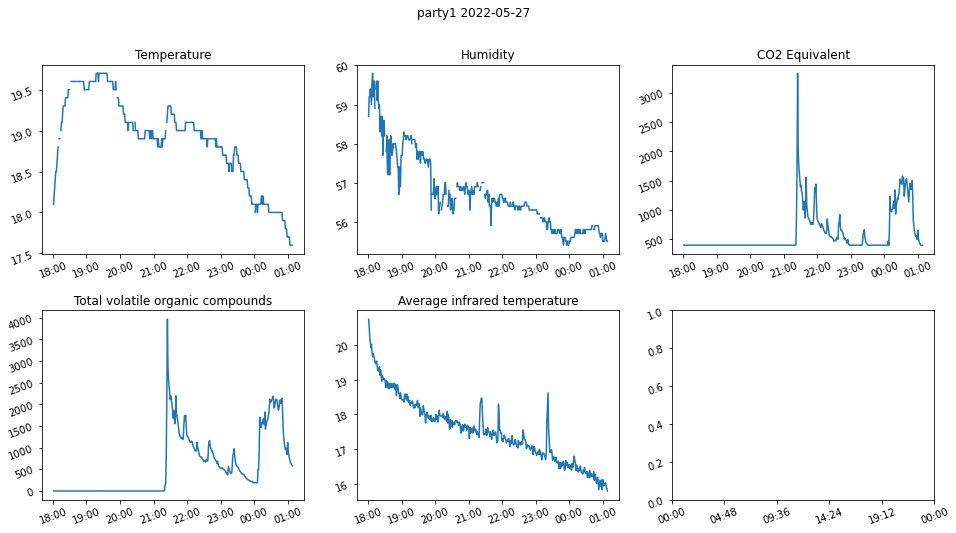

In [86]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("party1 {}".format(party1.date.min().date()))
barchart = party1.groupby("song").count()["timestamp"].sort_values(ascending=False).head(12)
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(party1.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(party1.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(party1.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(party1.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(party1.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

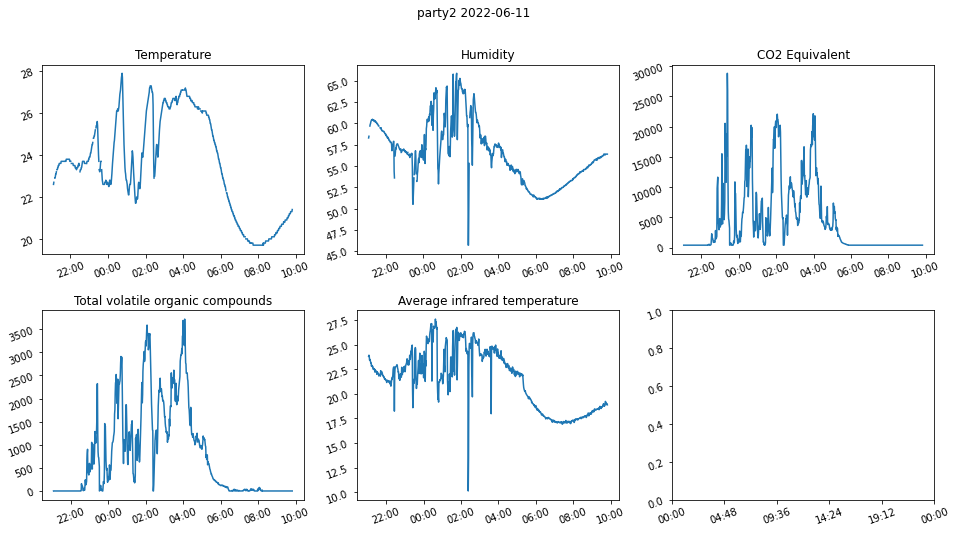

In [87]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("party2 {}".format(party2.date.min().date()))
barchart = party2.groupby("song").count()["timestamp"].sort_values(ascending=False).head(12)
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(party2.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(party2.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(party2.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(party2.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(party2.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

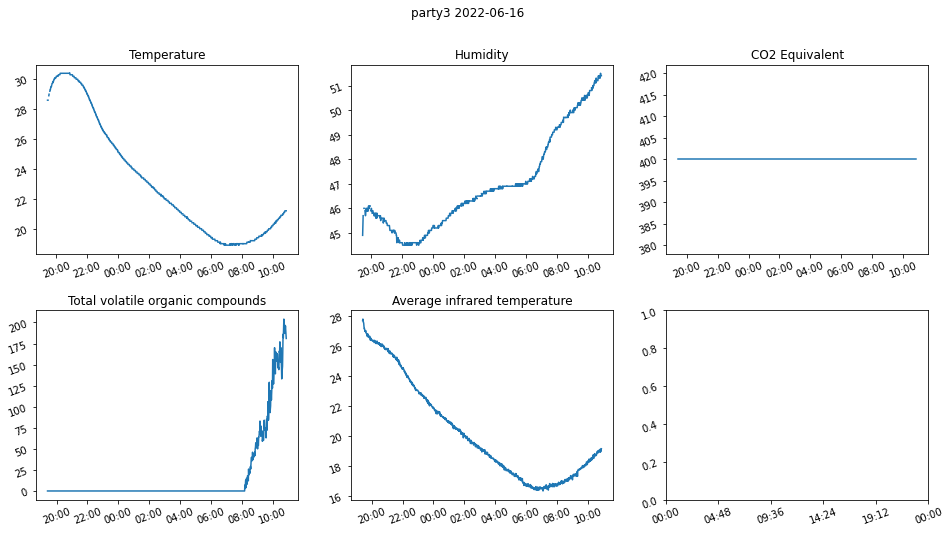

In [88]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("party3 {}".format(party3.date.min().date()))
barchart = party3.groupby("song").count()["timestamp"].sort_values(ascending=False).head(12)
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(party3.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(party3.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(party3.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(party3.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(party3.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

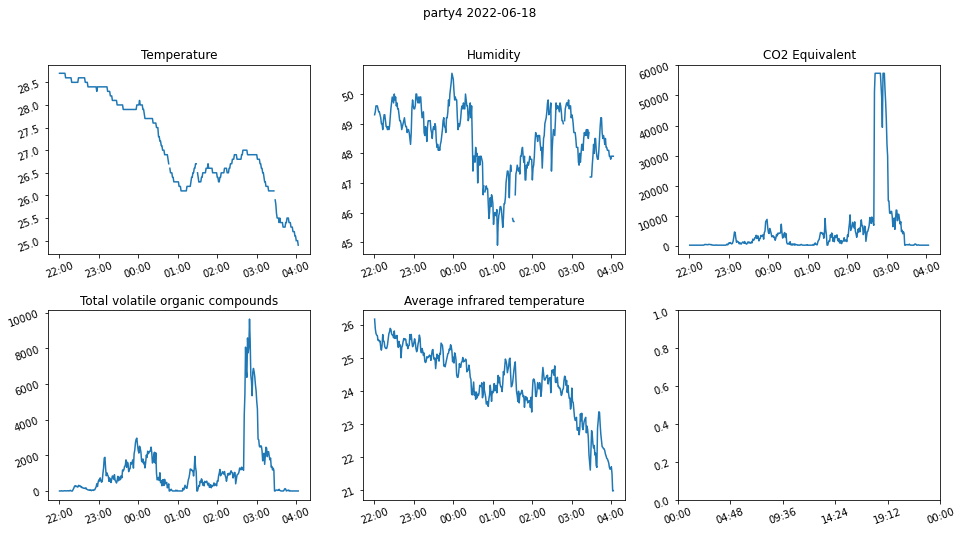

In [89]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("party4 {}".format(party4.date.min().date()))
barchart = party4.groupby("song").count()["timestamp"].sort_values(ascending=False).head(12)
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(party4.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(party4.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(party4.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(party4.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(party4.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

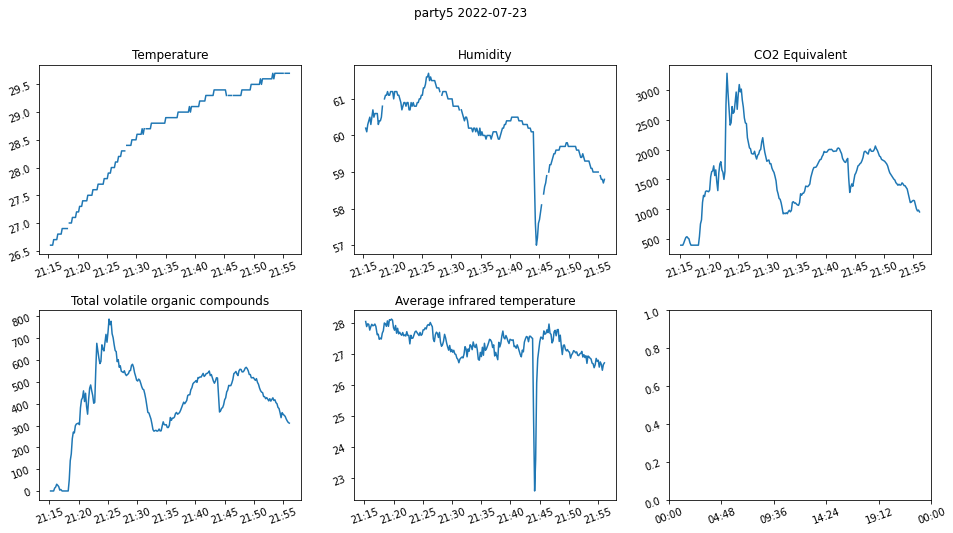

In [90]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("party5 {}".format(party5.date.min().date()))
barchart = party5.groupby("song").count()["timestamp"].sort_values(ascending=False).head(12)
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(party5.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(party5.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(party5.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(party5.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(party5.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

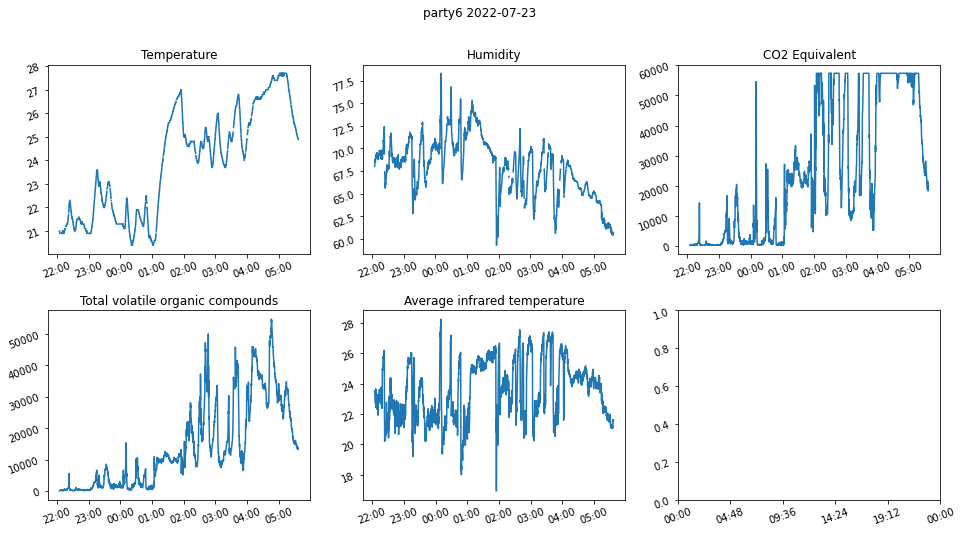

In [91]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("party6 {}".format(party5.date.min().date()))
barchart = party6.groupby("song").count()["timestamp"].sort_values(ascending=False).head(12)
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(party6.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(party6.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(party6.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(party6.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(party6.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

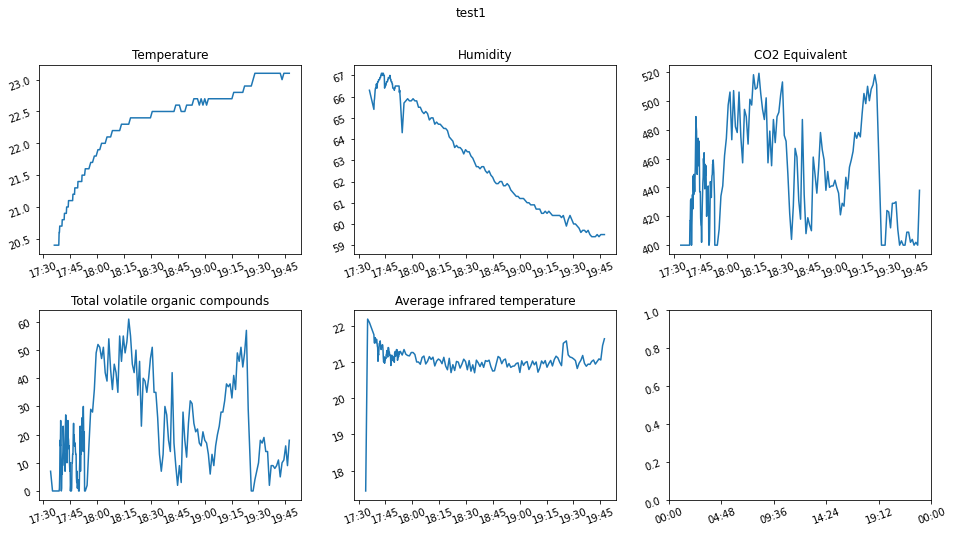

In [92]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("test1")
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(test1.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(test1.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(test1.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(test1.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(test1.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

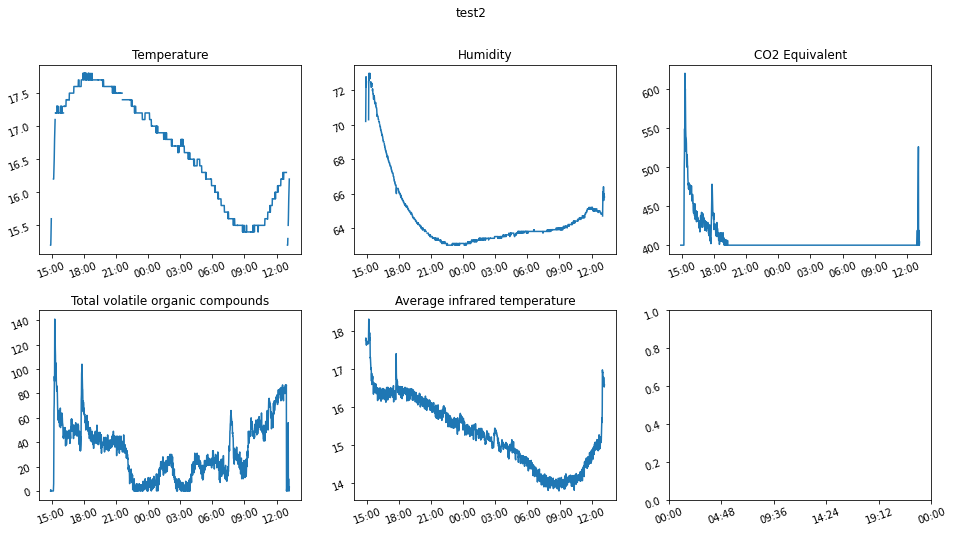

In [93]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("test2")
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(test2.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(test2.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(test2.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(test2.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(test2.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

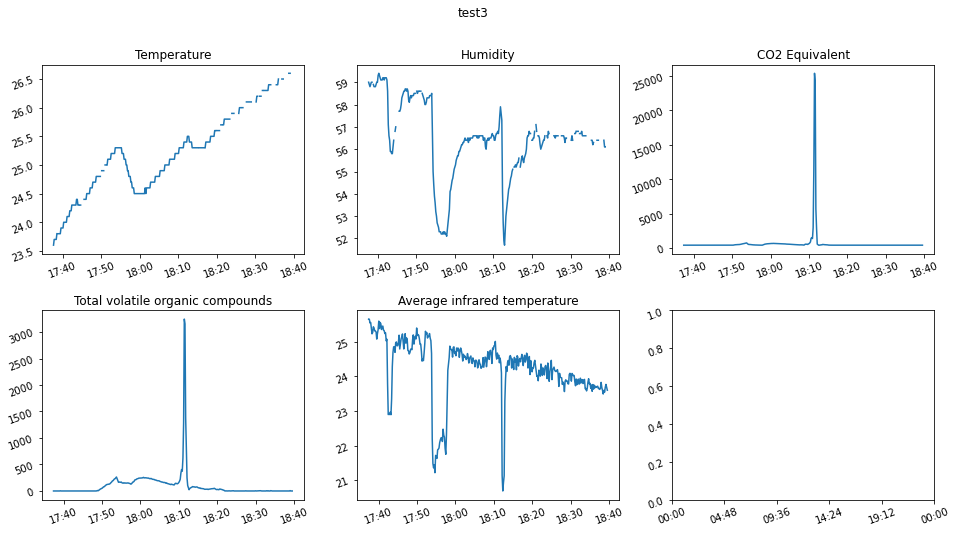

In [94]:
fig, ax = plt.subplots(2,3, figsize=(16,8))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("test3")
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.tick_params(labelrotation=20);
ax[0,0].plot(test3.set_index("timestamp")["temperature"]);
ax[0,0].set_title("Temperature");
ax[0,1].plot(test3.set_index("timestamp")["humidity"]);
ax[0,1].set_title("Humidity");
ax[0,2].plot(test3.set_index("timestamp")["eCO2"]);
ax[0,2].set_title("CO2 Equivalent");
ax[1,0].plot(test3.set_index("timestamp")["TVOC"]);
ax[1,0].set_title("Total volatile organic compounds");
ax[1,1].plot(test3.set_index("timestamp")["inf_mean"]);
ax[1,1].set_title("Average infrared temperature");

Investigating the ventilation activity model

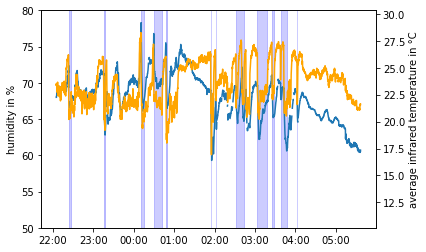

In [95]:
fig, ax = plt.subplots()
party6_time = party6.set_index("timestamp")
ax.plot(party6_time["humidity"])
ax.set_ylim([50,80])
ax.fill_between(party6_time.index, 0, 1, where=party6_time["ventilation_pred"], alpha=0.2, transform=ax.get_xaxis_transform(), color="blue")
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylabel("humidity in %")
ax2 = ax.twinx()
ax2.plot(party6_time["inf_mean"], color="orange")
ax2.set_ylim([data["inf_mean"].min(), data["inf_mean"].max()])
ax2.set_ylabel("average infrared temperature in °C")
ax2.xaxis.set_major_formatter(xfmt);

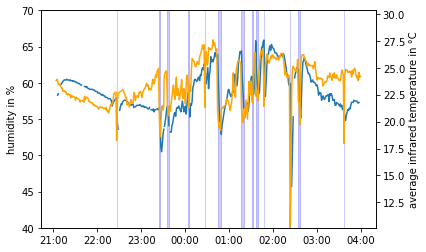

In [96]:
fig, ax = plt.subplots()
party2_trim = party2.query("timestamp < '2022-06-12 04:00:00'").set_index("timestamp")
ax.plot(party2_trim["humidity"])
ax.set_ylim([40,70])
ax.fill_between(party2_trim.index, 0, 1, where=party2_trim["ventilation_pred"], alpha=0.2, transform=ax.get_xaxis_transform(), color="blue")
ax.xaxis.set_major_formatter(xfmt)
ax.set_ylabel("humidity in %")
ax2 = ax.twinx()
ax2.plot(party2_trim["inf_mean"], color="orange")
ax2.set_ylim([data["inf_mean"].min(), data["inf_mean"].max()])
ax2.set_ylabel("average infrared temperature in °C")
ax2.xaxis.set_major_formatter(xfmt);

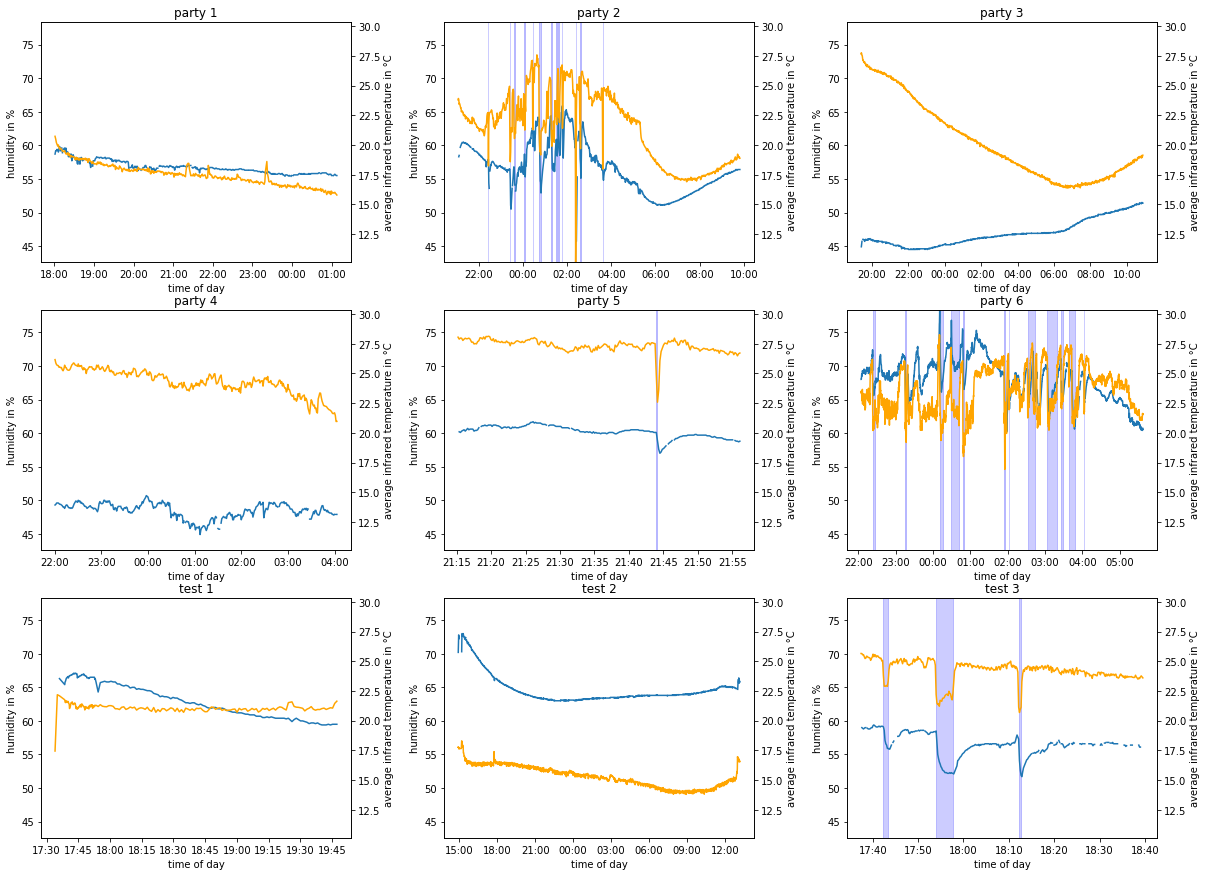

In [97]:
fig, ax = plt.subplots(3,3, figsize=(20,15))
plt.subplots_adjust(wspace=0.3)
labels=["party 1", "party 2", "party 3", "party 4", "party 5", "party 6", "test 1", "test 2", "test 3"]
for index, party in enumerate([party1, party2, party3, party4, party5, party6, test1, test2, test3]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["humidity"])
    ax[x,y].fill_between(party.set_index("timestamp").index, 0, 1, where=party.set_index("timestamp")["ventilation_pred"], alpha=0.2, transform=ax[x,y].get_xaxis_transform(), color="blue")
    #ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std1"])
    #ax[x,y].plot(party.set_index("timestamp")["num_people_pred"])
    ax[x,y].set_ylim([data["humidity"].min(),data["humidity"].max()])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_xlabel("time of day")
    ax[x,y].set_title(labels[index])
    ax[x,y].set_ylabel("humidity in %")
    ax2 = ax[x,y].twinx()
    ax2.plot(party.set_index("timestamp")["inf_mean"], color="orange")
    ax2.set_ylim([data["inf_mean"].min(), data["inf_mean"].max()])
    ax2.set_ylabel("average infrared temperature in °C")
    ax2.xaxis.set_major_formatter(xfmt);

Looking for correlation in the dataset

In [98]:
data["eCO2diff"] = data["eCO2"].diff()

In [99]:
data.loc[data["eCO2diff"] >= 0, "eCO2diff"] = np.nan

In [100]:
data.corr()

,temperature,humidity,eCO2,TVOC,inf0,inf1,inf2,inf3,inf4,inf5,...,ventilation_pred,num_people_pred_std,num_people_pred,num_people_pred_rf,num_people_pred_std_floor,num_people_pred_hum,num_people_pred_std_comb,num_people_pred_std1,num_people_pred_std2,eCO2diff
temperature,1.000000,-0.239413,0.416665,0.388699,0.914284,0.908766,0.900773,0.880584,0.866205,0.860165,...,0.107193,0.329427,0.115994,-0.621185,0.274334,-0.200863,0.280602,0.520007,0.346779,-0.155909
humidity,-0.239413,1.000000,0.352379,0.352633,-0.026965,-0.025602,-0.007499,0.011638,0.044138,0.067882,...,0.166364,0.401018,0.541225,0.326734,0.443300,0.972190,0.436516,0.177827,0.402743,-0.045412
eCO2,0.416665,0.352379,1.000000,0.956620,0.395841,0.386072,0.389070,0.379161,0.381059,0.391510,...,0.160125,0.213446,0.372872,-0.118205,0.202720,0.366729,0.200975,0.328648,0.288164,-0.288988
TVOC,0.388699,0.352633,0.956620,1.000000,0.359006,0.348770,0.351599,0.341563,0.341728,0.351326,...,0.172673,0.177892,0.326216,-0.132514,0.168851,0.366191,0.167119,0.258545,0.244558,-0.255538
inf0,0.914284,-0.026965,0.395841,0.359006,1.000000,0.994207,0.992747,0.985380,0.979447,0.974661,...,0.039099,0.430296,0.187719,-0.536765,0.378904,0.010539,0.386450,0.590500,0.419425,-0.028075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
num_people_pred_hum,-0.200863,0.972190,0.366729,0.366191,0.010539,0.012193,0.031438,0.050702,0.085146,0.111479,...,0.166819,0.453909,0.586091,0.306721,0.496443,1.000000,0.491455,0.242554,0.463173,-0.056566
num_people_pred_std_comb,0.280602,0.436516,0.200975,0.167119,0.386450,0.387495,0.405508,0.425412,0.459273,0.484225,...,0.294457,0.982053,0.769702,0.121931,0.994826,0.491455,1.000000,0.983957,0.933843,-0.201540
num_people_pred_std1,0.520007,0.177827,0.328648,0.258545,0.590500,0.586241,0.584987,0.585561,0.593487,0.599771,...,0.129660,1.000000,0.632960,-0.140421,0.972857,0.242554,0.983957,1.000000,0.976476,-0.167957
num_people_pred_std2,0.346779,0.402743,0.288164,0.244558,0.419425,0.417419,0.433100,0.446204,0.478697,0.502414,...,0.316539,0.921281,0.829635,0.095522,0.931665,0.463173,0.933843,0.976476,1.000000,-0.269150


In [101]:
data.corr().to_csv("data_corr.csv")

eCO2 and TVOC are strongly correlated 96%
temperature is strongly correlated with infrared data 90% with a cyclic behaivor

eCO2 and TVOC are weakly correlated to temperature, humidity and infrared data 40%
humidity is weakly correlated with temperature (anti), CO2 and TVOC 35%
hour is weakly anti correlated with eCO2 and TVOC

num_people is not correlated with anything

In [103]:
party_people.corr()["num_people"].sort_values(ascending=False)

num_people              1.000000
num_people_pred_rf      0.971044
num_people_pred         0.917905
num_people_pred_std1    0.901943
num_people_pred_std2    0.889230
                          ...   
inf40                  -0.448684
inf58                  -0.449963
inf8                   -0.451128
inf56                  -0.455718
inf48                  -0.456771
Name: num_people, Length: 89, dtype: float64

In [104]:
from pandas.core.indexing import IndexingError
# Function to plot infrared images
def inf_matrix(df, n_cols=4, labels=None):
    n_rows = math.ceil(df.shape[0]/n_cols)
    fig, ax = plt.subplots(n_rows,n_cols, figsize=(16,4*n_rows))
    plt.subplots_adjust(hspace=0.5, right=0.8)
    try:
        tmin, tmax = df.iloc[:,5:69].min().min(), df.iloc[:,5:69].max().max()
    except IndexingError:
        tmin, tmax = df[5:69].min(), df[5:69].max()
    for i, val in enumerate(df.values):
        x, y = math.floor(i/n_cols), i%n_cols
        if n_rows == 1:
            axis = ax[y]
        else:
            axis = ax[x,y]
        cax = axis.matshow(np.rot90(val[5:69].reshape(8,8).astype("float"), k=3), vmin=tmin, vmax=tmax)
        if labels != None and len(labels) > i:
            axis.set_title(labels[i])
    fig.colorbar(cax, ax=ax)

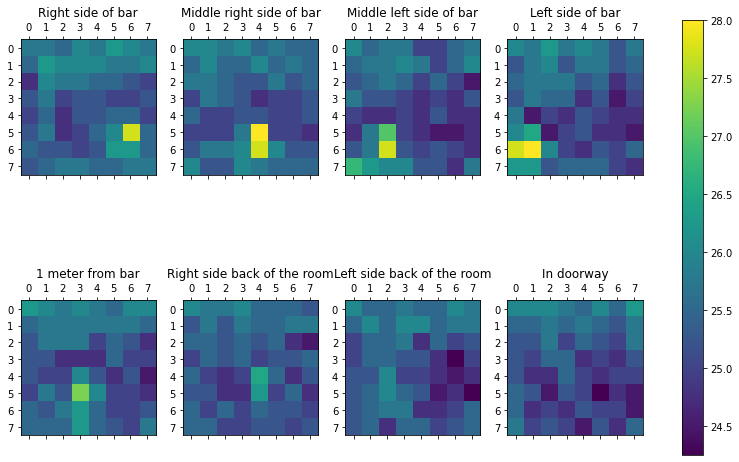

In [105]:
inf_matrix(data.iloc[4457:4465], labels=["Right side of bar", "Middle right side of bar", "Middle left side of bar", "Left side of bar", "1 meter from bar", "Right side back of the room", "Left side back of the room", "In doorway"])

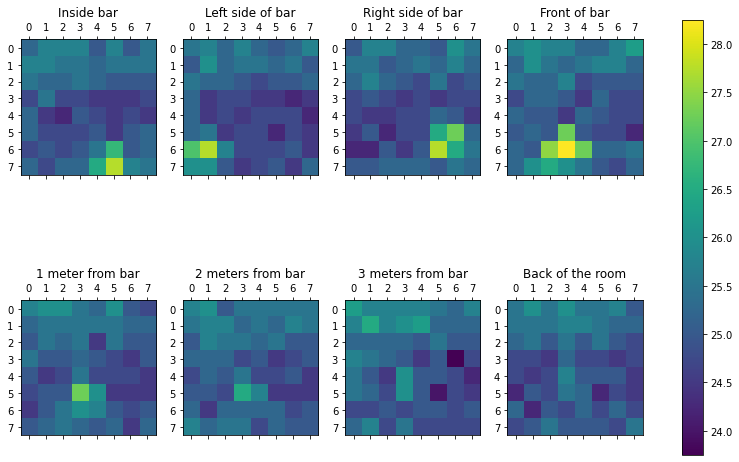

In [106]:
inf_matrix(data.iloc[4506:4516].drop(4507).drop(4510), labels=["Inside bar", "Left side of bar", "Right side of bar", "Front of bar", "1 meter from bar", "2 meters from bar", "3 meters from bar", "Back of the room"])

In [107]:
# fog is not visible
# standing at bar left side
# firing the fog machine once has no significant impact
data.iloc[4460,5:69].max(), data.iloc[4508, 5:69].max()

(28.0, 27.75)

In [108]:
# standing at bar right side
data.iloc[4457,5:69].max(), data.iloc[4511, 5:69].max()
# no impact

(27.75, 28.25)

In [109]:
#standing at bar middle
data.iloc[4458,5:69].max(), data.iloc[4509, 5:69].max()
# no impact

(28.0, 27.75)

In [110]:
# 1 meter from bar
data.iloc[4461,5:69].max(), data.iloc[4512, 5:69].max()
# no impact

(27.25, 27.25)

In [111]:
# 2 meter from bar
data.iloc[4461,5:69].max(), data.iloc[4513, 5:69].max()
# 0.75 degree difference

(27.25, 26.5)

In [112]:
# 3 meter from bar
data.iloc[4461,5:69].max(), data.iloc[4514, 5:69].max()
# 0.75 degree difference

(27.25, 26.5)

In [113]:
# 3 meter from bar
data.iloc[4461,5:69].max(), data.iloc[4515, 5:69].max()
# 1.25 degree difference

(27.25, 26.0)

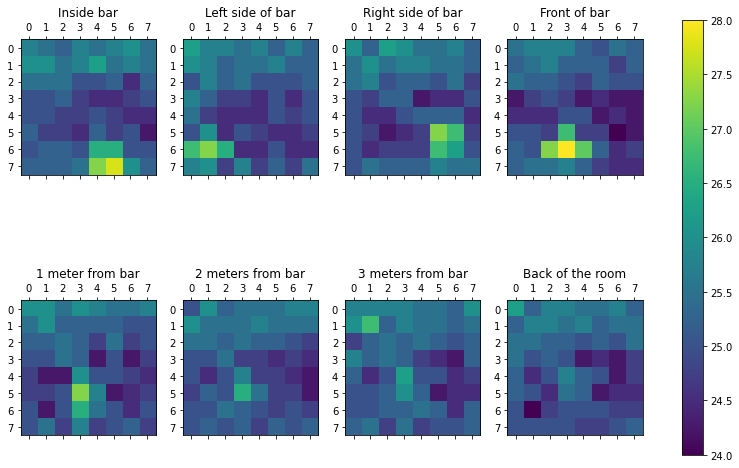

In [114]:
inf_matrix(data.iloc[4524:4532], labels=["Inside bar", "Left side of bar", "Right side of bar", "Front of bar", "1 meter from bar", "2 meters from bar", "3 meters from bar", "Back of the room"])

In [115]:
# fog is not visible
# standing at bar left side
# 0.75 degrees difference
data.iloc[4460,5:69].max(), data.iloc[4525, 5:69].max()

(28.0, 27.25)

In [116]:
# standing at bar right side
data.iloc[4457,5:69].max(), data.iloc[4526, 5:69].max()
# no impact

(27.75, 27.25)

In [117]:
#standing at bar middle
data.iloc[4458,5:69].max(), data.iloc[4527, 5:69].max()
# no impact

(28.0, 28.0)

In [118]:
# 1 meter from bar
data.iloc[4461,5:69].max(), data.iloc[4528, 5:69].max()
# no impact

(27.25, 27.25)

In [119]:
# 2 meter from bar
data.iloc[4461,5:69].max(), data.iloc[4529, 5:69].max()
# 0.75 degree difference

(27.25, 26.5)

In [120]:
# 3 meter from bar
data.iloc[4461,5:69].max(), data.iloc[4530, 5:69].max()
# 1 degree difference

(27.25, 26.75)

In [121]:
# 3 meter from bar
data.iloc[4461,5:69].max(), data.iloc[4531, 5:69].max()
# 1 degree difference

(27.25, 26.25)

In [122]:
# conclusion: fog only affects readings >2 meters from bar by reduction of maximum 1.25 degrees

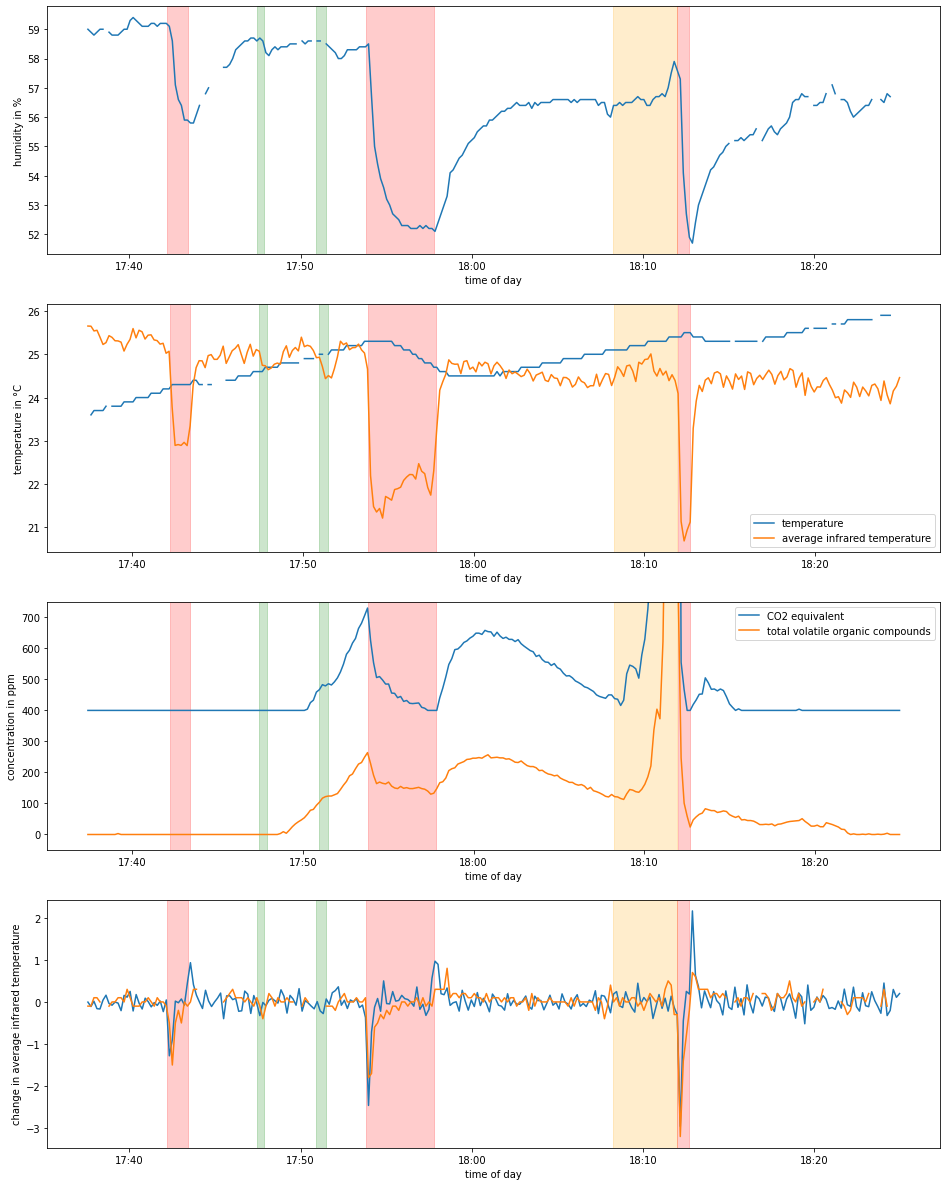

In [123]:
fig, ax = plt.subplots(4, figsize=((16,21)))
smoke_test = test3.query("timestamp < '2022-07-29 18:25:00'").set_index("timestamp")
ax[0].plot(smoke_test["humidity"]);
ax[1].plot(smoke_test["temperature"]);
ax[1].plot(smoke_test["inf_mean"]);
ax[2].plot(smoke_test["eCO2"]);
ax[2].plot(smoke_test["TVOC"]);
ax[3].plot(smoke_test["inf_mean_diff"])
ax[3].plot(smoke_test["humidity_diff"].shift(-1))
for a in ax.flatten():
    a.xaxis.set_major_formatter(xfmt)
    a.axvspan(pd.to_datetime("2022-07-29 17:42:12"),pd.to_datetime("2022-07-29 17:43:24"), color="red", alpha=0.2)
    a.axvspan(pd.to_datetime("2022-07-29 17:47:27"),pd.to_datetime("2022-07-29 17:47:52"), color="green", alpha=0.2)
    a.axvspan(pd.to_datetime("2022-07-29 17:50:55"),pd.to_datetime("2022-07-29 17:51:29"), color="green", alpha=0.2)
    a.axvspan(pd.to_datetime("2022-07-29 17:53:50"),pd.to_datetime("2022-07-29 17:57:48"), color="red", alpha=0.2)
    a.axvspan(pd.to_datetime("2022-07-29 18:08:15"),pd.to_datetime("2022-07-29 18:11:57"), color="orange", alpha=0.2)
    a.axvspan(pd.to_datetime("2022-07-29 18:11:58"),pd.to_datetime("2022-07-29 18:12:42"), color="red", alpha=0.2)
    a.set_xlabel("time of day")
ax[0].set_ylabel("humidity in %")
ax[1].set_ylabel("temperature in °C")
ax[2].set_ylabel("concentration in ppm")
ax[1].legend(["temperature", "average infrared temperature"], loc="lower right")
ax[2].legend(["CO2 equivalent", "total volatile organic compounds"], loc="upper right")
ax[2].set_ylim([-50,750])
ax[3].set_ylabel("change in average infrared temperature");

In [124]:
data["ventilation"] = np.nan
data.loc[test3.index, "ventilation"] = 0
data.loc[(data["timestamp"] >= "2022-07-29 17:42:12") & (data["timestamp"] <= "2022-07-29 17:43:24"), "ventilation"] = 1
data.loc[(data["timestamp"] >= "2022-07-29 17:53:50") & (data["timestamp"] <= "2022-07-29 17:57:48"), "ventilation"] = 1
data.loc[(data["timestamp"] >= "2022-07-29 18:11:58") & (data["timestamp"] <= "2022-07-29 18:12:42"), "ventilation"] = 1

In [125]:
#from sklearn.model_selection import GridSearchCV
#parameters = {"max_depth": range(1,20,1), "min_samples_split":range(2,20,1), "min_samples_leaf": range(1,20,1)}
#cv_mod = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, scoring="accuracy")
#cv_mod.best_estimator_

#results max_depth=2, min_samples_split=4

In [126]:
from sklearn.ensemble import RandomForestClassifier
cv_mod = RandomForestClassifier(max_depth=2, min_samples_split=4)
train_cols = ["inf_mean_diff", "inf_mean", "humidity_diff", "humidity_diff_shift", "humidity", "ventilation"]
train = data.loc[test3.index][train_cols].dropna()
cv_mod.fit(train[train_cols[:-1]], train["ventilation"])

RandomForestClassifier(max_depth=2, min_samples_split=4)

In [127]:
data.loc[(data[train_cols[:-1]].notna()).all(axis=1), "ventilation_pred2"] = cv_mod.predict(data[train_cols[:-1]].dropna())

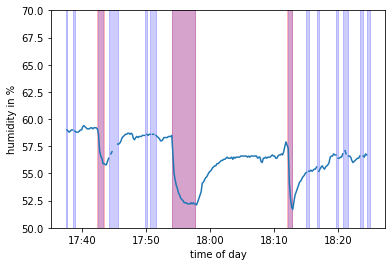

In [128]:
test3 = data.query("(timestamp >= '2022-07-29 00:00:00') & (timestamp < '2022-07-29 20:00:00')")
smoke_test = test3.query("timestamp < '2022-07-29 18:25:00'").set_index("timestamp")
fig, ax = plt.subplots()
ax.fill_between(smoke_test.index, 0, 1, where=smoke_test["ventilation_pred2"], alpha=0.2, transform=ax.get_xaxis_transform(), color="blue")
ax.fill_between(smoke_test.index, 0, 1, where=smoke_test["ventilation"], alpha=0.2, transform=ax.get_xaxis_transform(), color="red")
plt.plot(smoke_test["humidity"]);
plt.ylim([50,70]);
plt.xlabel("time of day")
plt.ylabel("humidity in %")
ax.xaxis.set_major_formatter(xfmt)

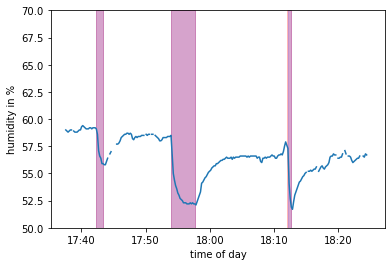

In [129]:
test3 = data.query("(timestamp >= '2022-07-29 00:00:00') & (timestamp < '2022-07-29 20:00:00')")
smoke_test = test3.query("timestamp < '2022-07-29 18:25:00'").set_index("timestamp")
fig, ax = plt.subplots()
ax.fill_between(smoke_test.index, 0, 1, where=smoke_test["ventilation_pred"], alpha=0.2, transform=ax.get_xaxis_transform(), color="blue")
ax.fill_between(smoke_test.index, 0, 1, where=smoke_test["ventilation"], alpha=0.2, transform=ax.get_xaxis_transform(), color="red")
plt.plot(smoke_test["humidity"]);
plt.ylim([50,70]);
plt.xlabel("time of day")
plt.ylabel("humidity in %")
ax.xaxis.set_major_formatter(xfmt)

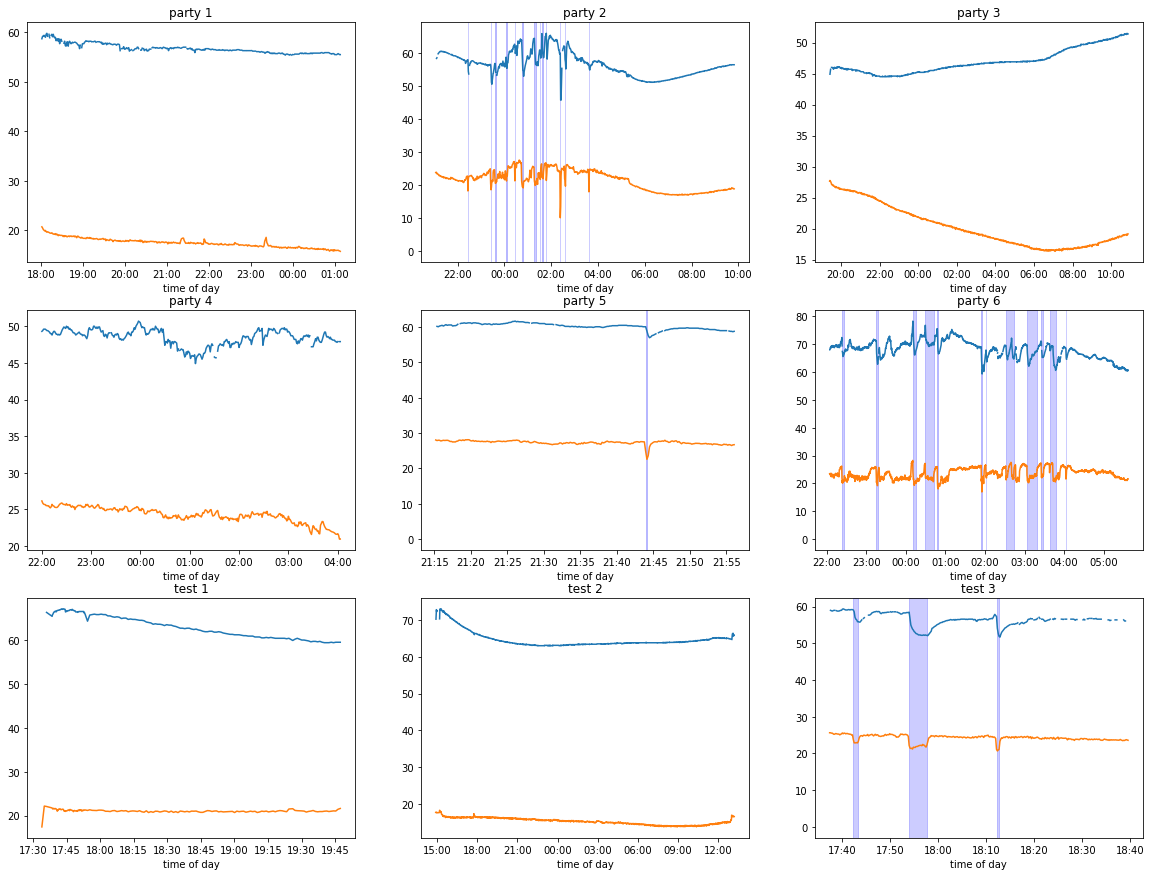

In [130]:
fig, ax = plt.subplots(3,3, figsize=(20,15))
labels=["party 1", "party 2", "party 3", "party 4", "party 5", "party 6", "test 1", "test 2", "test 3"]
for index, party in enumerate([party1, party2, party3, party4, party5, party6, test1, test2, test3]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["humidity"])
    ax[x,y].plot(party.set_index("timestamp")["inf_mean"])
    ax[x,y].fill_between(party.set_index("timestamp").index, 0, 1, where=party.set_index("timestamp")["ventilation_pred"], alpha=0.2, transform=ax[x,y].get_xaxis_transform(), color="blue")
    #ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std1"])
    #ax[x,y].plot(party.set_index("timestamp")["num_people_pred"])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_xlabel("time of day")
    ax[x,y].set_title(labels[index]);

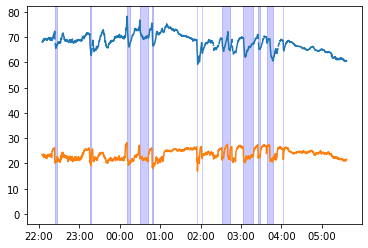

In [131]:
fig, ax = plt.subplots()
ax.plot(party6.set_index("timestamp")["humidity"])
ax.plot(party6.set_index("timestamp")["inf_mean"])
ax.fill_between(party6.set_index("timestamp").index, 0, 1, where=party6.set_index("timestamp")["ventilation_pred"], alpha=0.2, transform=ax.get_xaxis_transform(), color="blue")
ax.xaxis.set_major_formatter(xfmt);

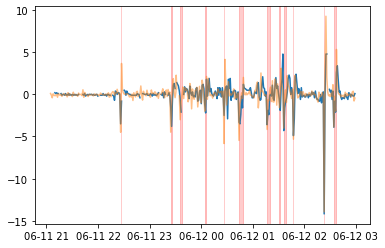

In [132]:
party2 = data.query("(timestamp >= '2022-06-11 00:00:00') & (timestamp < '2022-06-13 00:00:00')")
party2_test = party2.query("timestamp < '2022-06-12 03:00:00'").set_index("timestamp")
fig, ax = plt.subplots()
ax.fill_between(party2_test.index, 0, 1, where=party2_test["ventilation_pred"], alpha=0.2, transform=ax.get_xaxis_transform(), color="red")
plt.plot(party2_test["humidity_diff_shift"])
plt.plot(party2_test["inf_mean_diff"], alpha=0.5);

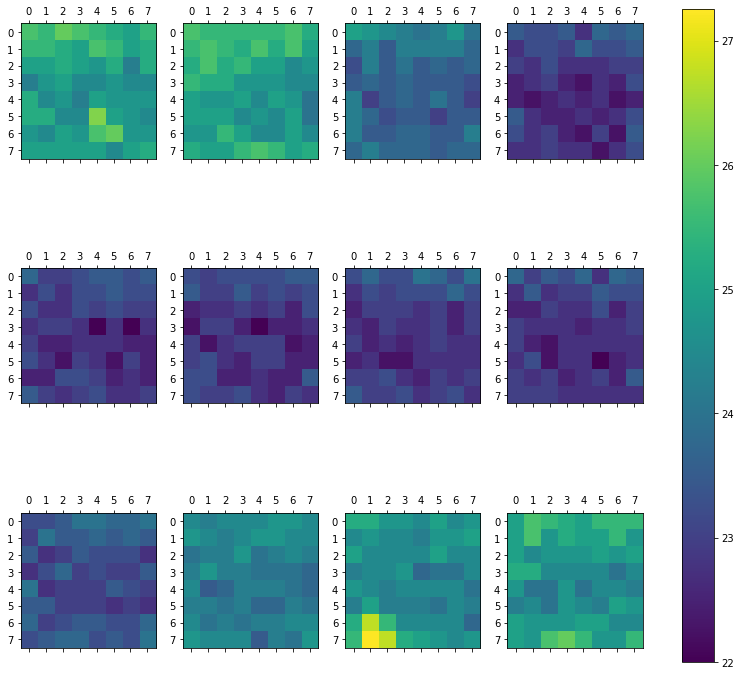

In [133]:
inf_matrix(data.iloc[4466:4478])

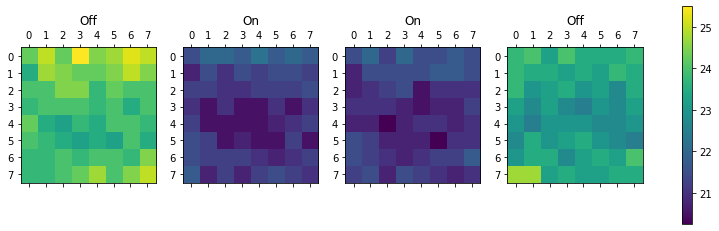

In [134]:
inf_matrix(data.iloc[4636:4642].drop(4638).drop(4639), labels=["Off", "On", "On", "Off"])

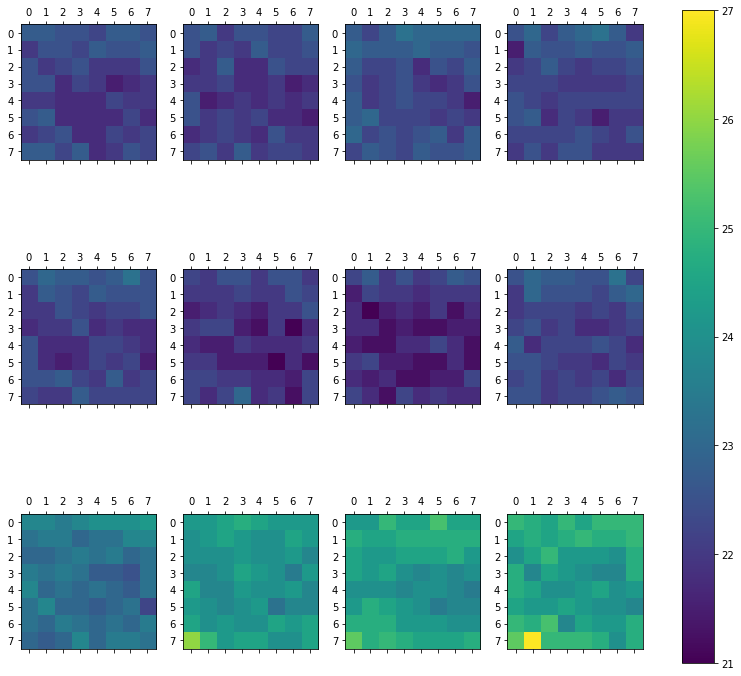

In [135]:
inf_matrix(data.iloc[4548:4560])

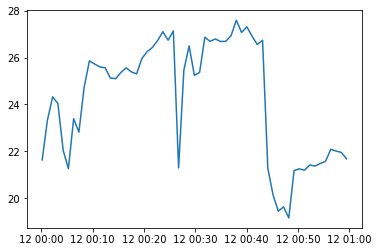

In [136]:
ven_test = party2.query("(timestamp > '2022-06-12 00:00:00') & (timestamp < '2022-06-12 01:00:00')")
plt.plot(ven_test.set_index("timestamp")["inf_mean"]);

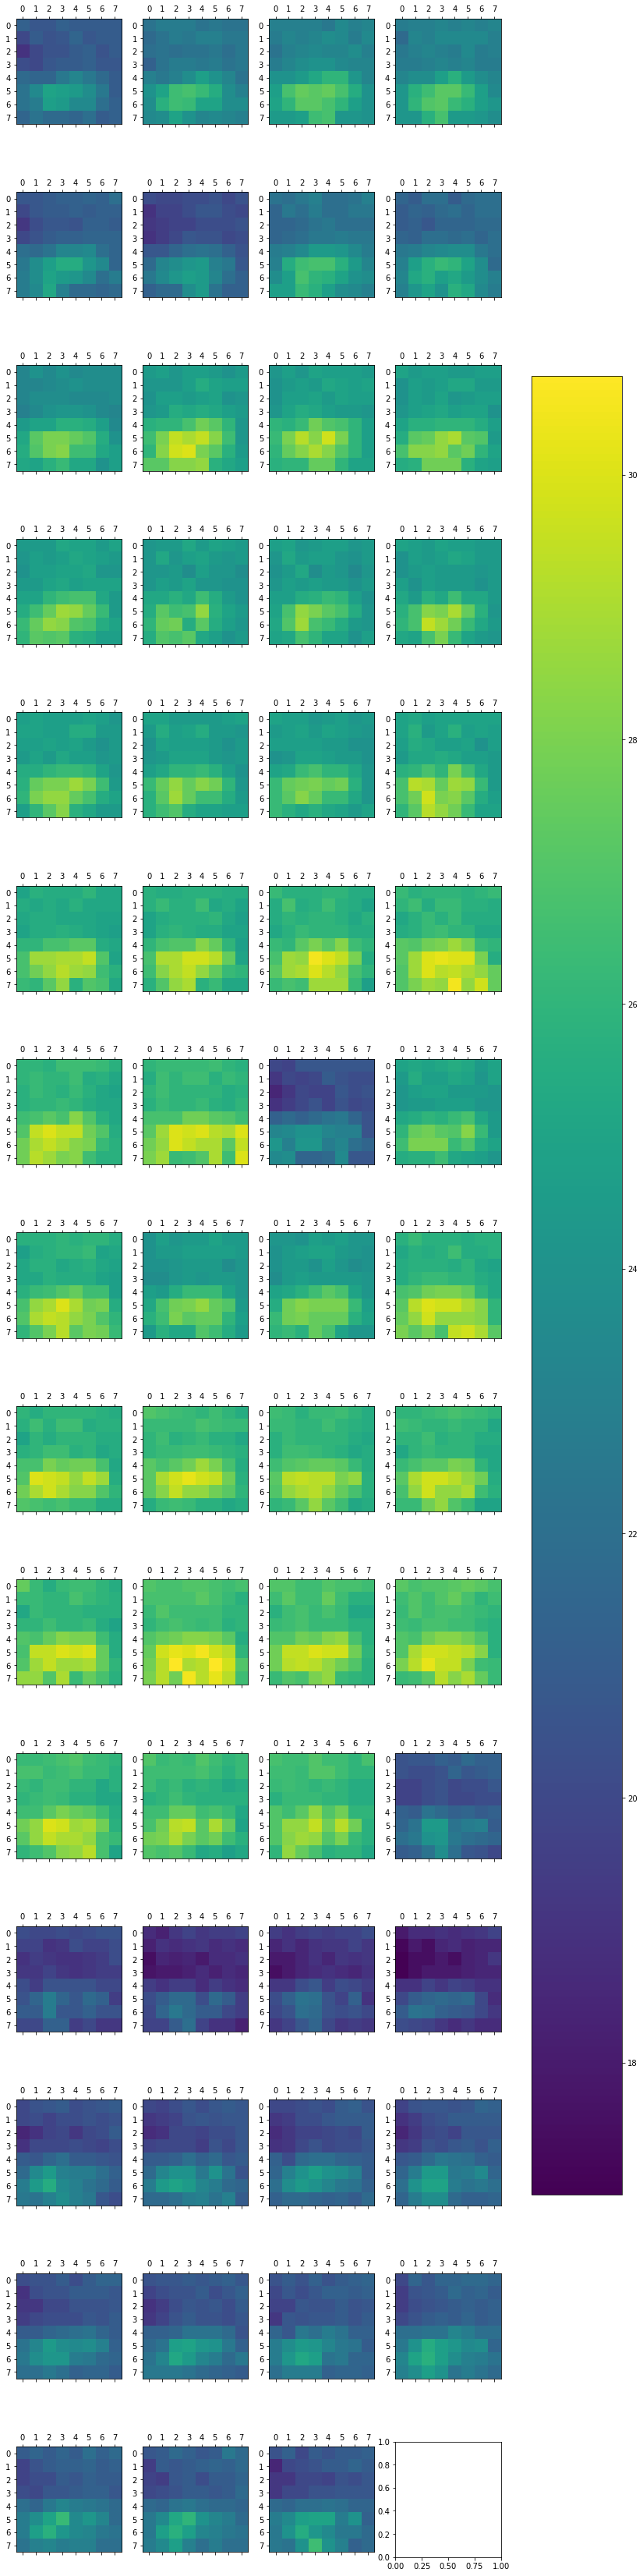

In [137]:
inf_matrix(ven_test)

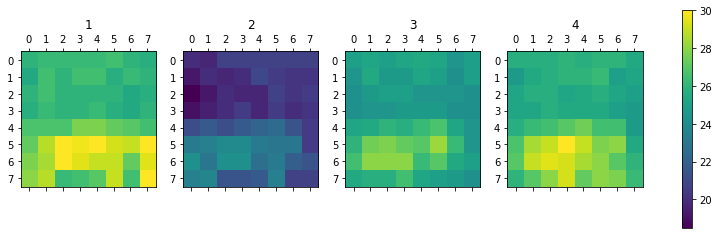

In [138]:
inf_matrix(data.iloc[2306:2310], labels=["1", "2", "3", "4"])

In [139]:
data.iloc[2306:2310][["inf_std", "inf_mean"]]

,inf_std,inf_mean
2306,1.433699,27.132812
2307,1.517017,21.296875
2308,1.093410,25.457031
2309,1.367131,26.500000


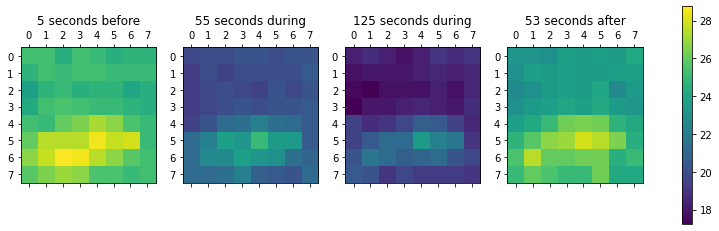

In [140]:
inf_matrix(data.iloc[[5184,5190,5196,5202]], labels=["5 seconds before", "55 seconds during", "125 seconds during", "53 seconds after"])

In [141]:
data.iloc[[5184,5190,5196,5202]][["num_people", "inf_std", "inf_mean"]]

,num_people,inf_std,inf_mean
5184,11.0,1.209641,25.695312
5190,13.0,1.331472,20.906250
5196,13.0,1.366746,19.195312
5202,13.0,1.336654,24.570312


In [142]:
party_people["num_people"].corr(party_people["inf_std"])

0.8591763515319768

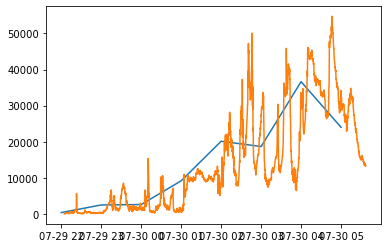

In [143]:
plt.plot(party6.groupby("hour_date").mean()["TVOC"]);
plt.plot(party6.set_index("timestamp")["TVOC"]);

In [144]:
data["eCO2"].corr(data["TVOC"])

0.9566199018012863

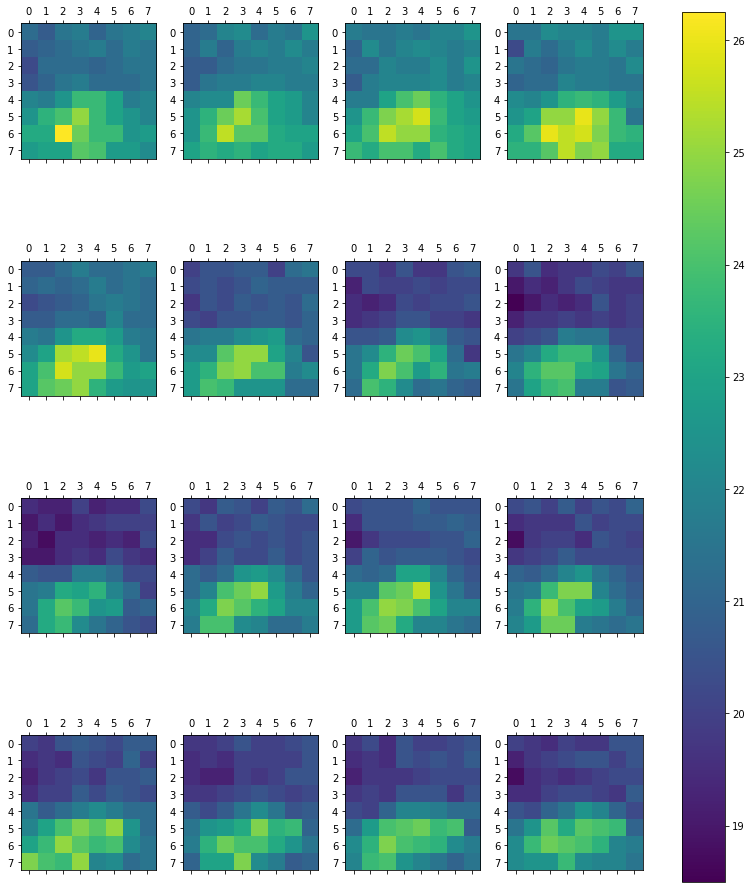

In [145]:
inf_matrix(data.iloc[5038:5054])

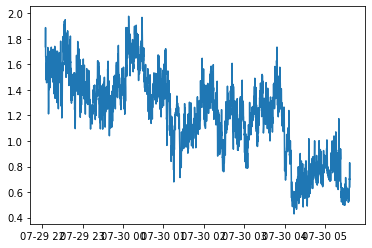

In [146]:
plt.plot(party6.set_index("timestamp")["inf_std"]);

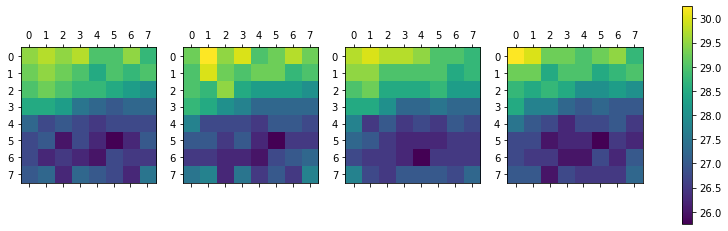

In [147]:
inf_matrix(data.iloc[2858:2862])

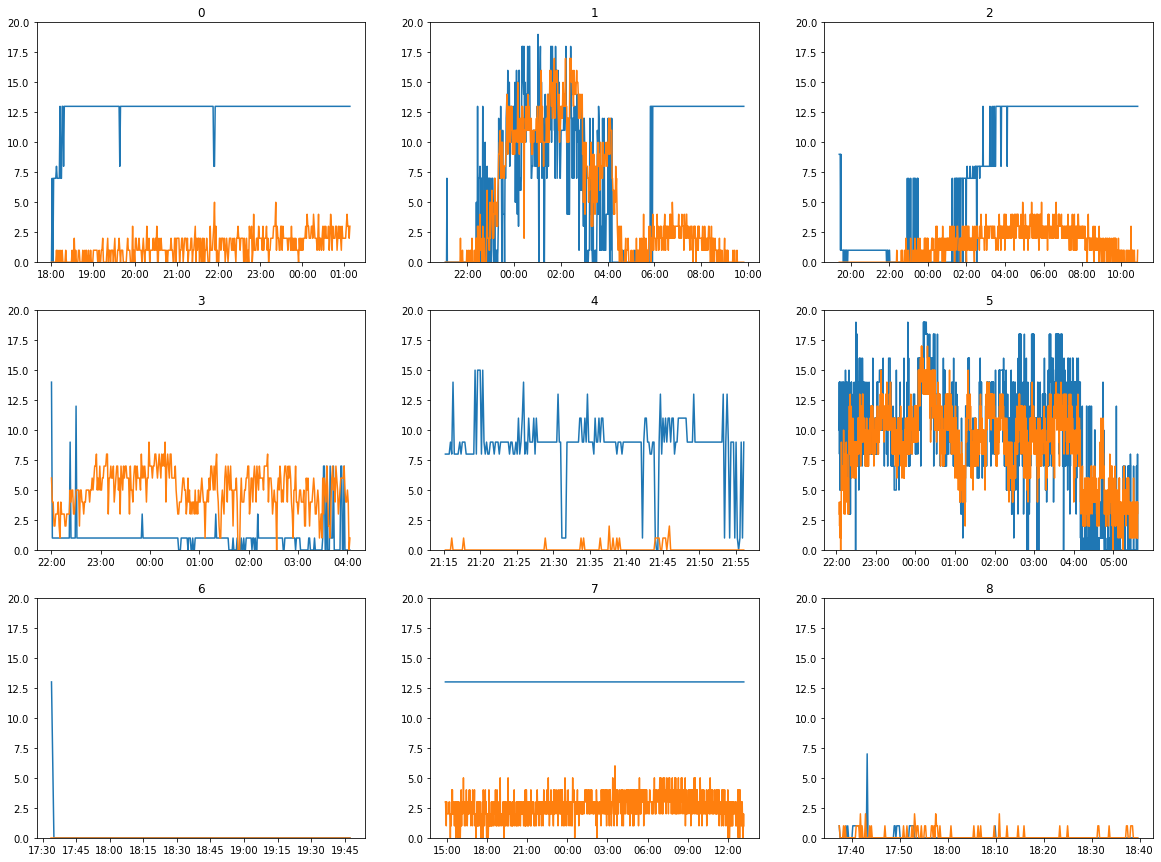

In [148]:
fig, ax = plt.subplots(3,3, figsize=(20,15))
for index, party in enumerate([party1, party2, party3, party4, party5, party6, test1, test2, test3]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_rf"])
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred"])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_ylim((0,20))
    ax[x,y].set_title(index);

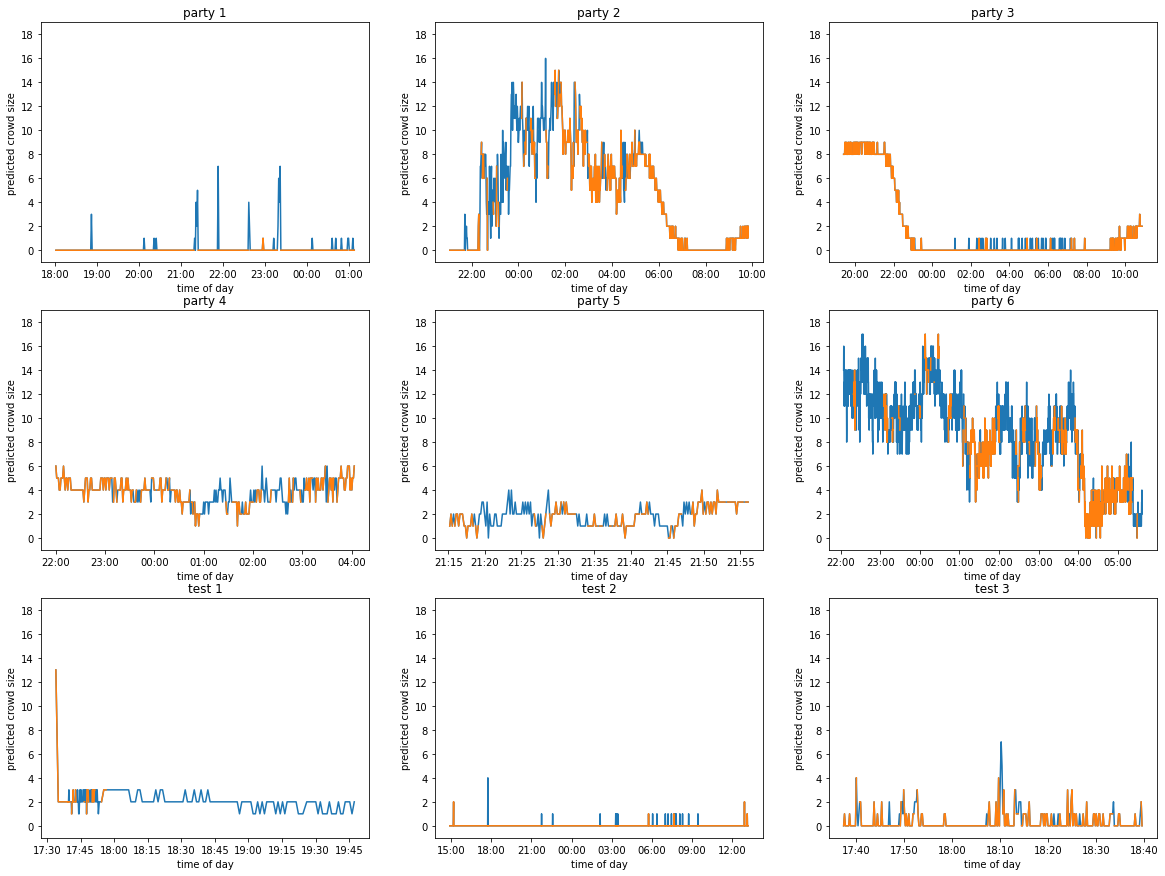

In [149]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(3,3, figsize=(20,15))
labels=["party 1", "party 2", "party 3", "party 4", "party 5", "party 6", "test 1", "test 2", "test 3"]
for index, party in enumerate([party1, party2, party3, party4, party5, party6, test1, test2, test3]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std"])
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std1"])
    #ax[x,y].plot(party.set_index("timestamp")["num_people_pred"])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_ylim((-1,19))
    ax[x,y].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[x,y].set_ylabel("predicted crowd size")
    ax[x,y].set_xlabel("time of day")
    ax[x,y].set_title(labels[index]);

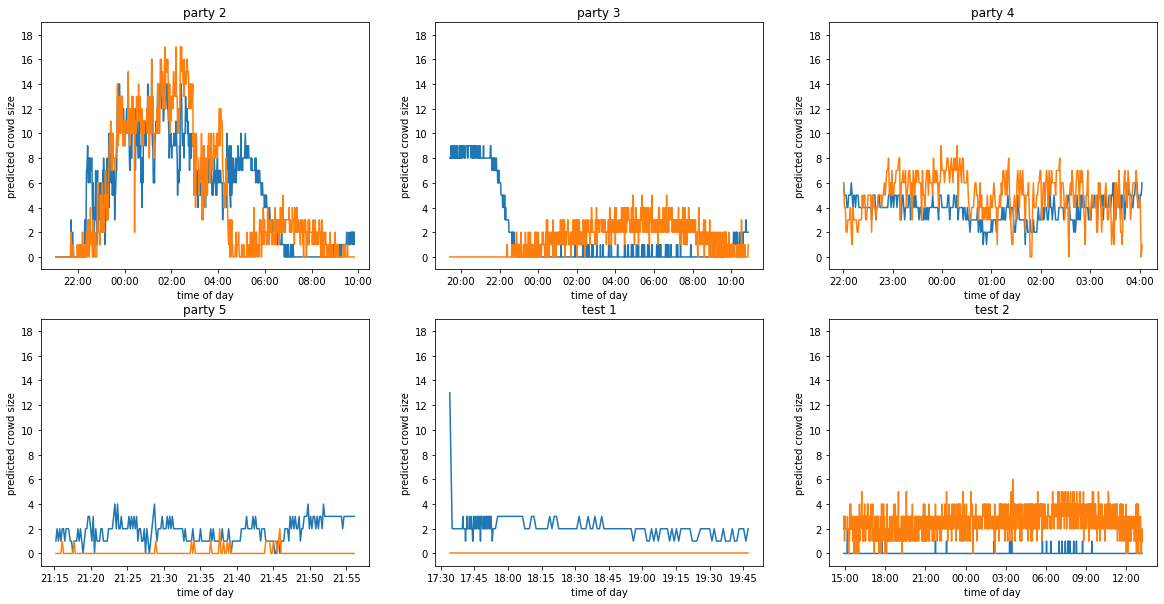

In [150]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(2,3, figsize=(20,10))
labels=["party 2", "party 3", "party 4", "party 5", "test 1", "test 2"]
for index, party in enumerate([party2, party3, party4, party5, test1, test2]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std"])
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred"])
    #ax[x,y].plot(party.set_index("timestamp")["num_people_pred"])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_ylim((-1,19))
    ax[x,y].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[x,y].set_ylabel("predicted crowd size")
    ax[x,y].set_xlabel("time of day")
    ax[x,y].set_title(labels[index]);

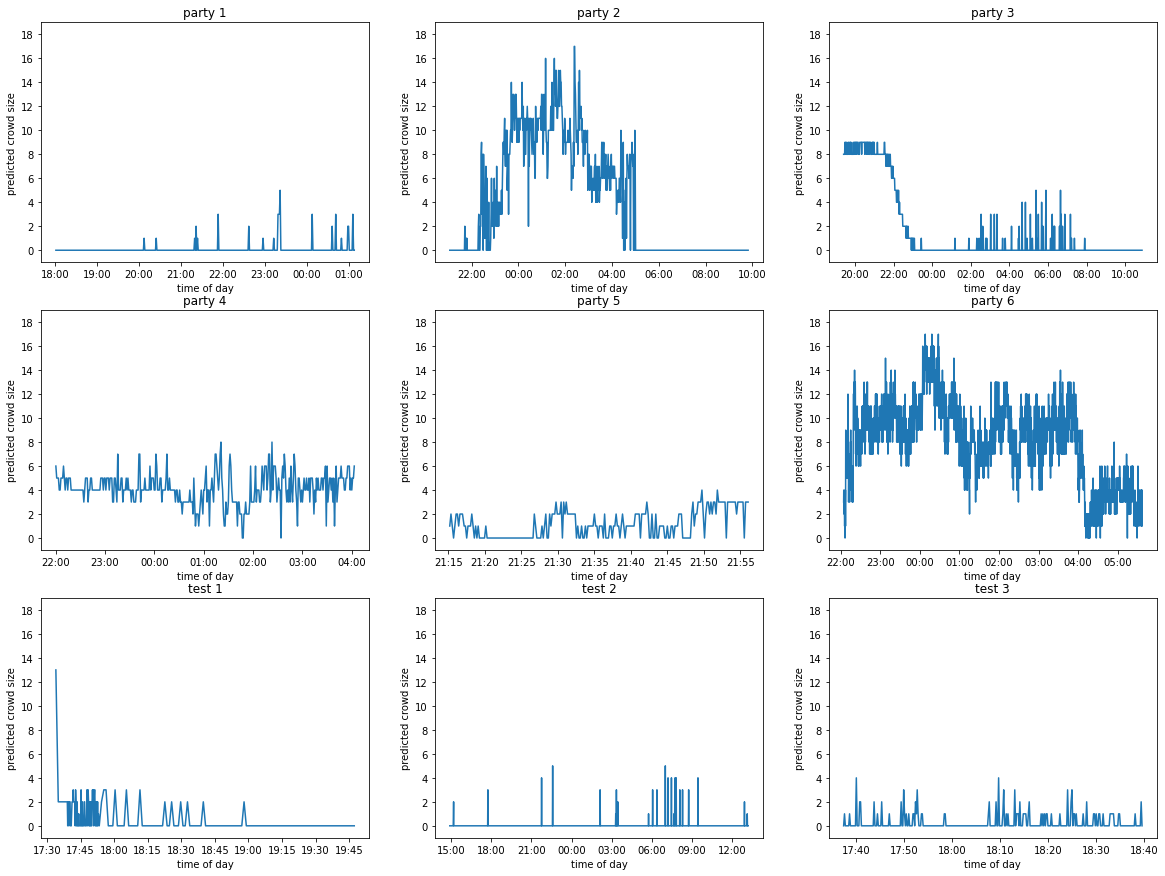

In [151]:
#combinedmodel
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(3,3, figsize=(20,15))
labels=["party 1", "party 2", "party 3", "party 4", "party 5", "party 6", "test 1", "test 2", "test 3"]
for index, party in enumerate([party1, party2, party3, party4, party5, party6, test1, test2, test3]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std2"])
    #ax[x,y].plot(party.set_index("timestamp")["num_people_pred"])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_ylim((-1,19))
    ax[x,y].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[x,y].set_ylabel("predicted crowd size")
    ax[x,y].set_xlabel("time of day")
    ax[x,y].set_title(labels[index]);

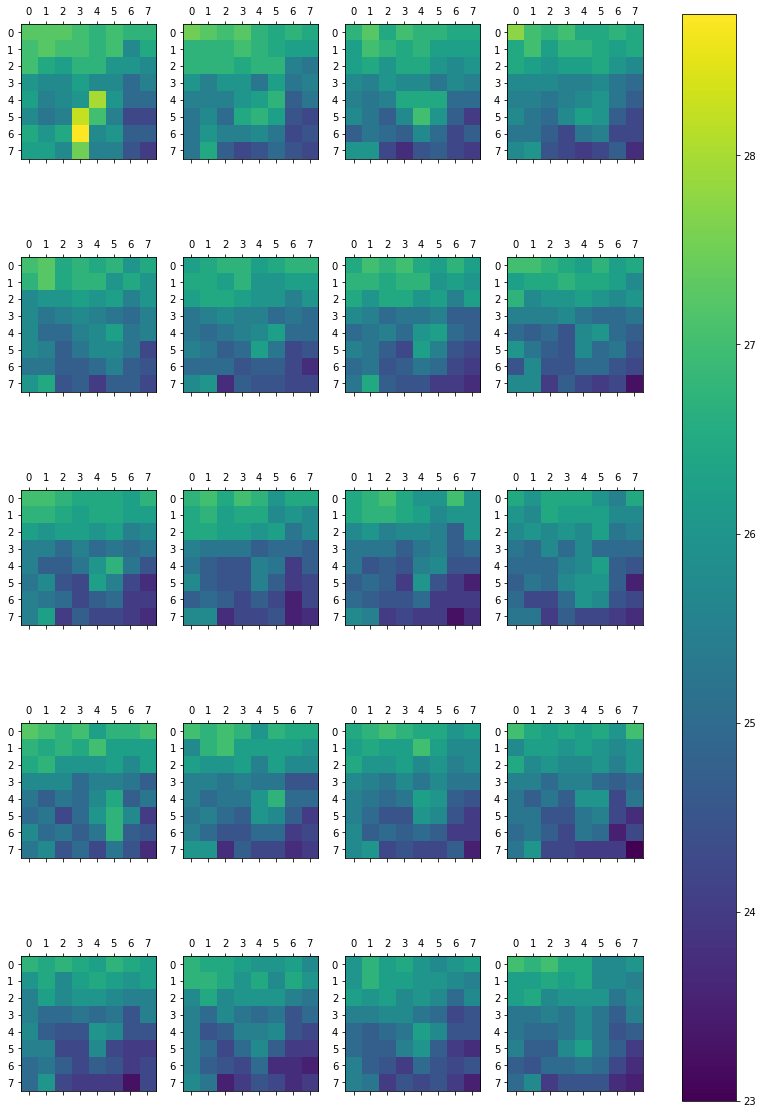

In [152]:
inf_matrix(data.iloc[party4[party4["num_people_pred_std1"].notna()].index[:20]])

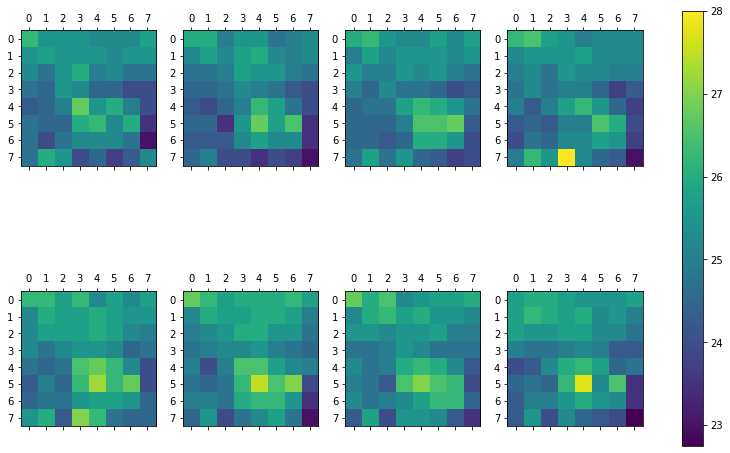

In [153]:
inf_matrix(data.iloc[3939-4:3939+4])

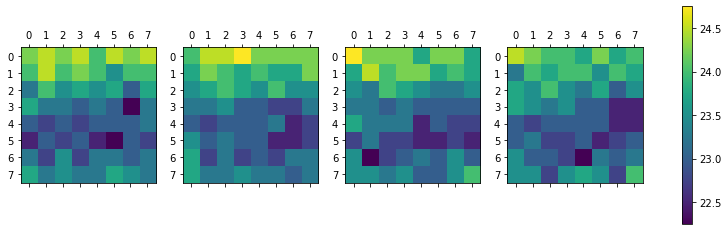

In [154]:
inf_matrix(data.iloc[party3[party3["num_people_pred_std"] ==1].index[:4]])#, labels=list(data.iloc[party3.index[:4]]["num_people_pred_std"].values))

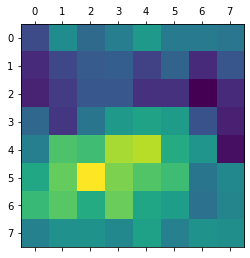

In [197]:
plt.matshow(np.rot90(data.mean(numeric_only=True)[5:69].values.reshape(8,8).astype("float"), k=3));

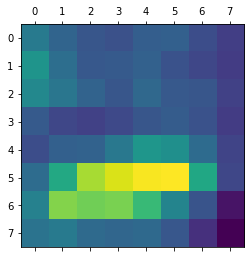

In [156]:
plt.matshow(np.rot90(data.std()[5:69].values.reshape(8,8).astype("float"), k=3));

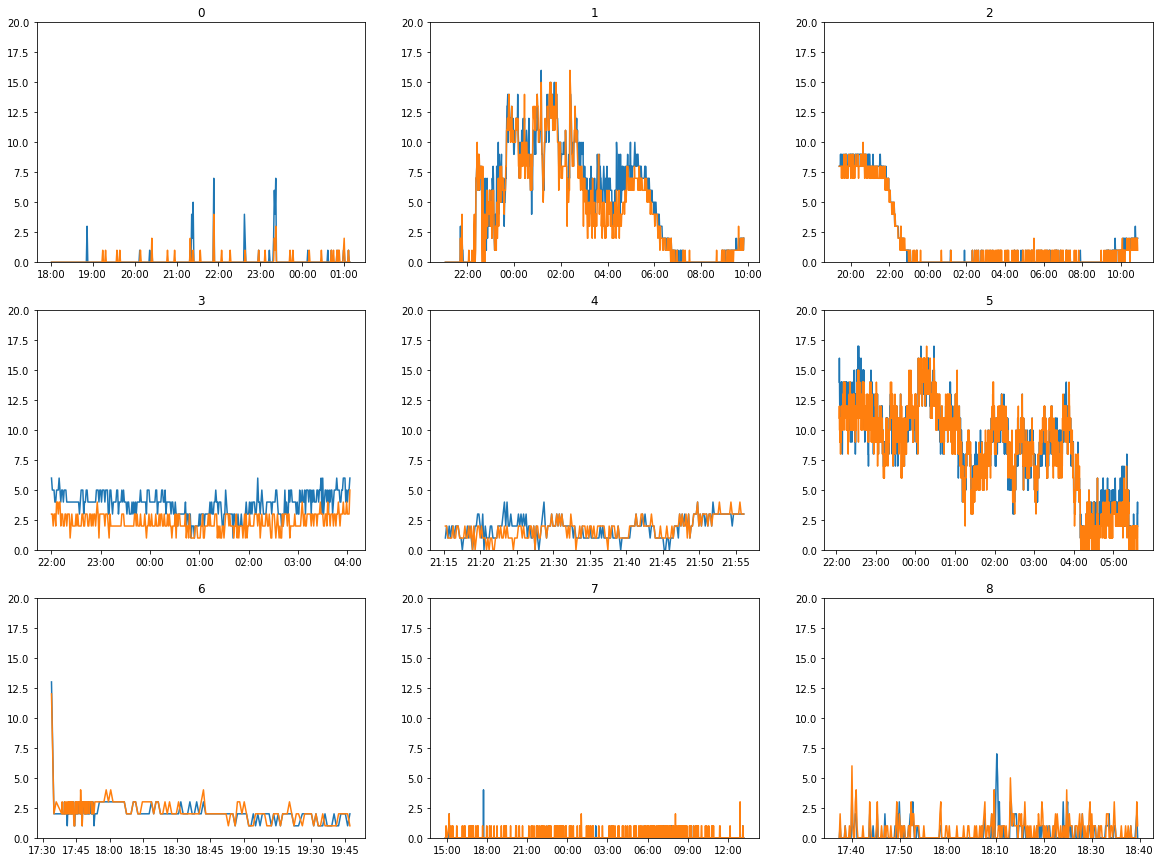

In [157]:
fig, ax = plt.subplots(3,3, figsize=(20,15))
for index, party in enumerate([party1, party2, party3, party4, party5, party6, test1, test2, test3]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std"])
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std_floor"])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_ylim((0,20))
    ax[x,y].set_title(index);

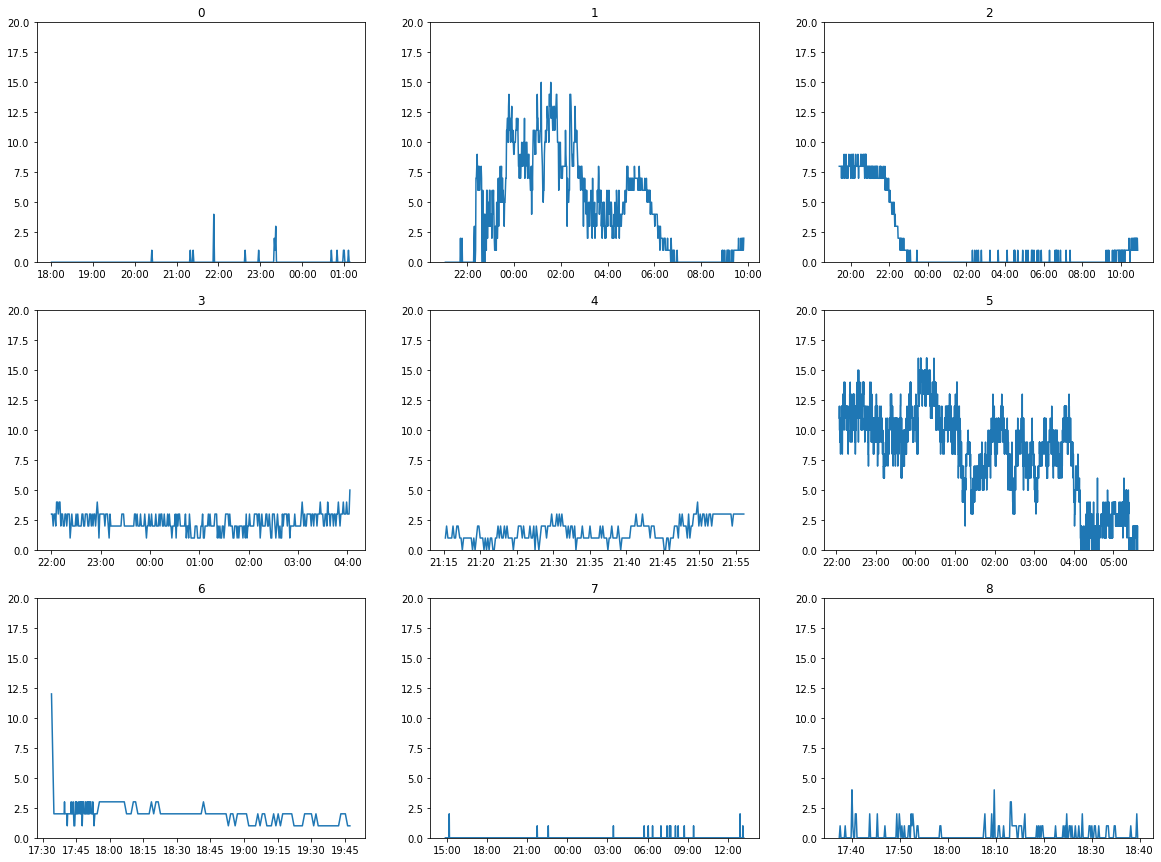

In [158]:
fig, ax = plt.subplots(3,3, figsize=(20,15))
for index, party in enumerate([party1, party2, party3, party4, party5, party6, test1, test2, test3]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std_comb"])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_ylim((0,20))
    ax[x,y].set_title(index);

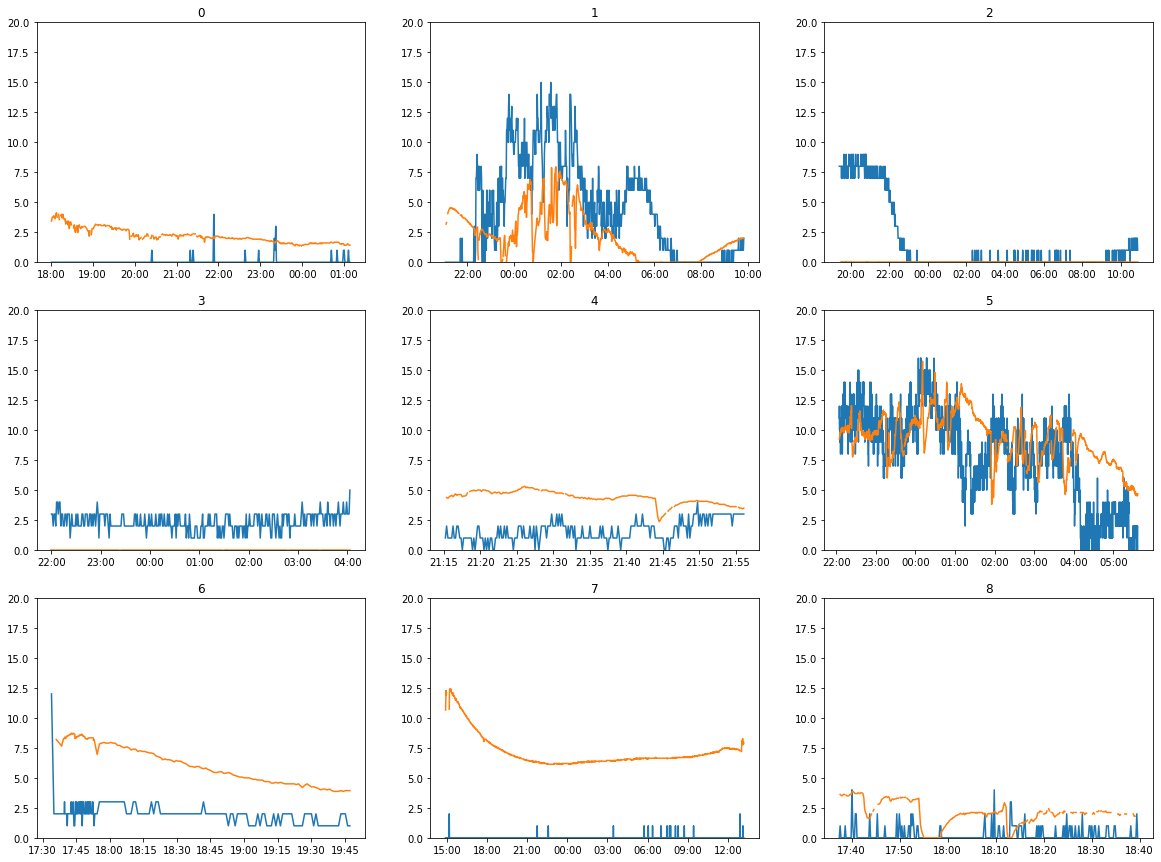

In [159]:
fig, ax = plt.subplots(3,3, figsize=(20,15))
for index, party in enumerate([party1, party2, party3, party4, party5, party6, test1, test2, test3]):
    x, y = math.floor(index/3), index%3
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_std_comb"])
    ax[x,y].plot(party.set_index("timestamp")["num_people_pred_hum"])
    ax[x,y].xaxis.set_major_formatter(xfmt)
    ax[x,y].set_ylim((0,20))
    ax[x,y].set_title(index);

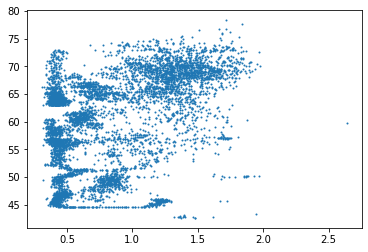

In [160]:
plt.scatter(data["inf_std"], data["humidity"], s=1);

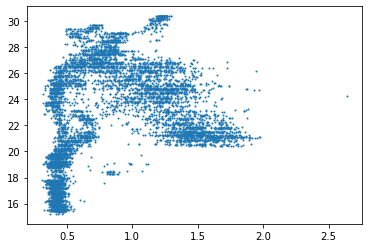

In [161]:
plt.scatter(data["inf_std"], data["temperature"], s=1);

In [162]:
index = party1[party1["num_people_pred_std"] > 0].index

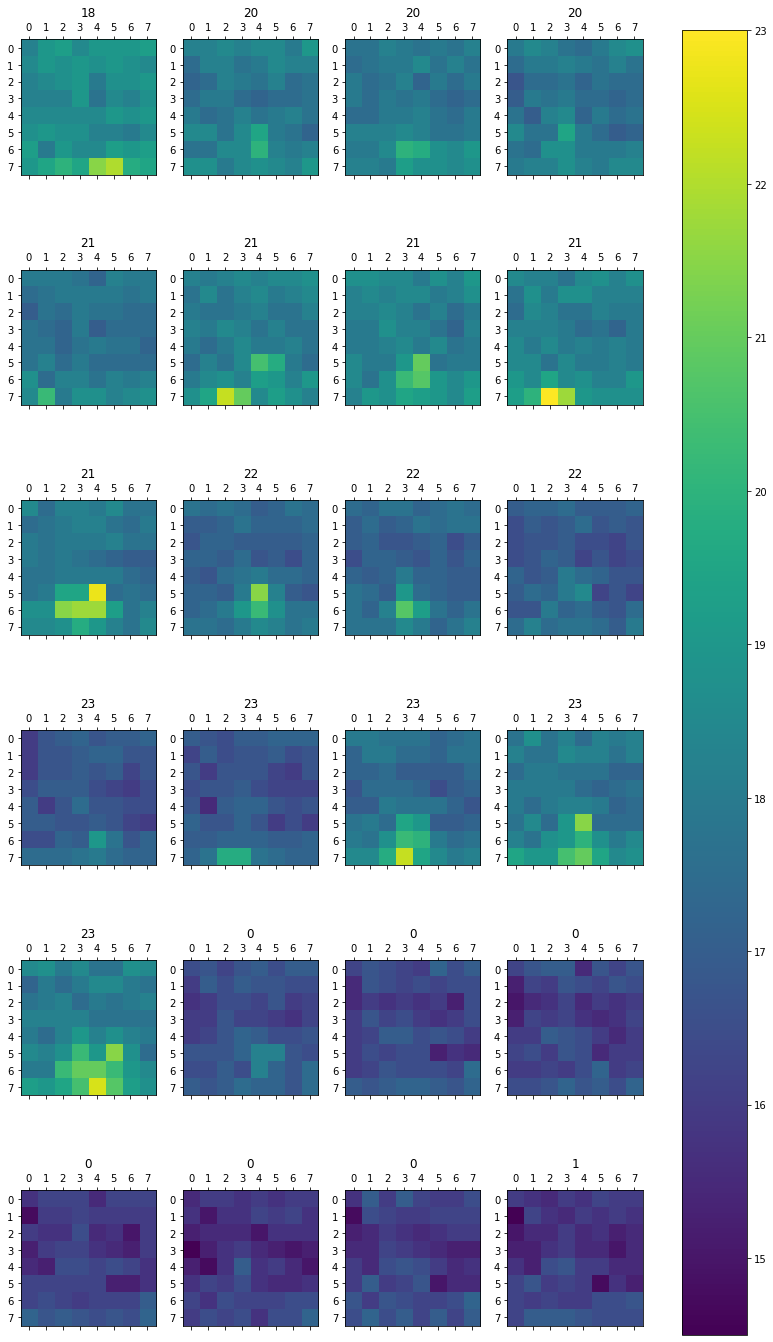

In [163]:
inf_matrix(data.iloc[index], labels=list(data.iloc[index]["hour"].values))

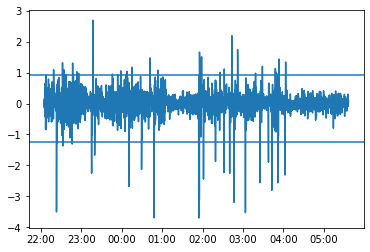

In [164]:
fig, ax = plt.subplots()
plt.plot(party6.set_index("timestamp")["inf_mean_diff"]);
plt.axhline(y=0.93)
plt.axhline(y=-1.23)
ax.xaxis.set_major_formatter(xfmt);

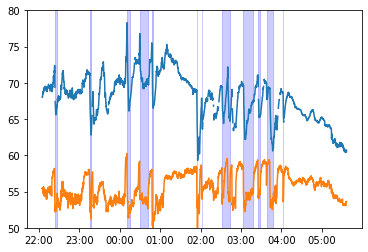

In [165]:
fig, ax = plt.subplots()
ax.plot(party6.set_index("timestamp")["humidity"])
ax.plot(party6.set_index("timestamp")["inf_mean"]+32)
ax.set_ylim([50,80])
ax.fill_between(party6.set_index("timestamp").index, 0, 1, where=party6.set_index("timestamp")["ventilation_pred"], alpha=0.2, transform=ax.get_xaxis_transform(), color="blue")
ax.xaxis.set_major_formatter(xfmt);

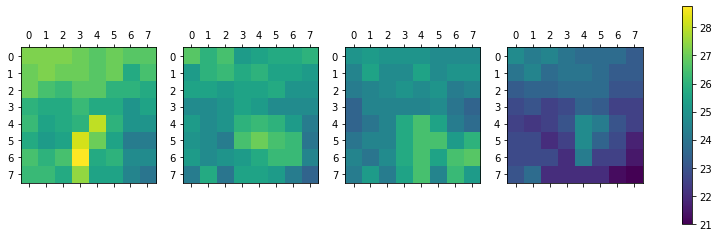

In [166]:
inf_matrix(data.iloc[party4.index[[0,100,200,300]]])

In [167]:
data_minute = data.groupby("minute").mean().copy(deep=True)

In [168]:
data_minute["crowd_size"] = data_minute["num_people_pred_std2"]
time_skip = (pd.Series(data_minute.index).diff() > pd.Timedelta("00:01:02")).values
measures = ["temperature", "humidity", "eCO2", "TVOC"]

for col in measures:
    diff_col = "{}_diff".format(col)
    meas_col = "{}_mood".format(col)
    data_minute[diff_col] = data_minute[col].diff()
    data_minute.loc[time_skip, diff_col] = np.nan
    data_minute[meas_col] = data_minute[diff_col] / data_minute["crowd_size"]
    data_minute.loc[~np.isfinite(data_minute[meas_col]), meas_col] = np.nan
    data_minute[meas_col+"_ven"] = data_minute[data_minute["ventilation_pred"] != 1][meas_col]
    data_minute[meas_col+"_0"] = data_minute[meas_col]
    data_minute.loc[(data_minute[meas_col] < 0), meas_col+"_0"] = 0

In [169]:
test1_m = data_minute.query("(index < '2022-05-10 00:00:00') & (index >= '2022-05-09 00:00:00')")
test2_m = data_minute.query("(index >= '2022-05-24 00:00:00') & (index < '2022-05-26 00:00:00')")
party1_m = data_minute.query("(index >= '2022-05-27 00:00:00') & (index < '2022-05-29 00:00:00')")
party2_m = data_minute.query("(index >= '2022-06-11 00:00:00') & (index < '2022-06-13 00:00:00')")
party3_m = data_minute.query("(index >= '2022-06-16 00:00:00') & (index < '2022-06-18 00:00:00')")
party4_m = data_minute.query("(index >= '2022-06-18 22:00:00') & (index < '2022-06-20 00:00:00')")
party5_m = data_minute.query("(index >= '2022-07-23 00:00:00') & (index < '2022-07-24 00:00:00')")
test3_m = data_minute.query("(index >= '2022-07-29 00:00:00') & (index < '2022-07-29 20:00:00')")
party6_m = data_minute.query("(index >= '2022-07-29 20:00:00') & (index < '2022-07-30 07:00:00')")

In [170]:
mood_cols = data_minute.columns[-12:]
mood_cols

Index(['temperature_mood', 'temperature_mood_ven', 'temperature_mood_0',
       'humidity_mood', 'humidity_mood_ven', 'humidity_mood_0', 'eCO2_mood',
       'eCO2_mood_ven', 'eCO2_mood_0', 'TVOC_mood', 'TVOC_mood_ven',
       'TVOC_mood_0'],
      dtype='object')

In [171]:
data = data.join(data_minute[mood_cols], on="minute") 

In [172]:
measures = data.groupby(["hour_date", "song"]).mean()[mood_cols].reset_index(drop=True)

In [173]:
measures

,temperature_mood,temperature_mood_ven,temperature_mood_0,humidity_mood,humidity_mood_ven,humidity_mood_0,eCO2_mood,eCO2_mood_ven,eCO2_mood_0,TVOC_mood,TVOC_mood_ven,TVOC_mood_0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,0.000000,0.000000,0.066667,0.066667,0.066667,30.666667,30.666667,30.666667,21.333333,21.333333,21.333333
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
528,0.000000,0.000000,0.000000,-0.033333,-0.033333,0.000000,0.000000,0.000000,0.000000,206.333333,206.333333,206.333333
529,0.005965,0.005965,0.005965,-0.018117,-0.018117,0.003838,-46.057644,-46.057644,101.333333,-180.958208,-180.958208,46.032331
530,0.001379,0.001379,0.007507,-0.000305,-0.000305,0.011457,-71.268577,-71.268577,528.845802,-10.408059,-10.408059,221.422006
531,-0.045604,-0.045604,0.000000,0.017766,0.017766,0.035714,-254.642857,-254.642857,0.000000,-409.905678,-409.905678,51.583333


In [174]:
for suffix in ["", "_ven", "_0"]:
    data["mood{}".format(suffix)] = (data["temperature_mood{}".format(suffix)] / data["temperature_mood{}".format(suffix)].max()) + (data["humidity_mood".format(suffix)] / data["humidity_mood".format(suffix)].max())

In [175]:
song_count = data.groupby(["hour_date", "song"]).mean().groupby("song").count().sort_values("temperature",ascending=False)
song_count

,temperature,humidity,eCO2,TVOC,inf0,inf1,inf2,inf3,inf4,inf5,...,humidity_mood_0,eCO2_mood,eCO2_mood_ven,eCO2_mood_0,TVOC_mood,TVOC_mood_ven,TVOC_mood_0,mood,mood_ven,mood_0
song,,,,,,,,,,,,,,,,,,,,,
Tream - LEBENSLANG - HBz Remix,9,9,9,9,9,9,9,9,9,9,...,6,7,7,7,7,7,7,6,6,6
Julian Sommer - Dicht im Flieger,7,7,7,7,7,7,7,7,7,7,...,6,6,6,6,6,6,6,6,6,6
DJ Robin - Layla,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
Little Sis Nora - MDMA,7,7,7,7,7,7,7,7,7,7,...,6,6,6,6,6,6,6,6,6,6
Electric Callboy - Spaceman (feat. FiNCH),6,6,6,6,6,6,6,6,6,6,...,5,5,4,5,5,4,5,5,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gestört aber GeiL - Wünsch Dir was - Radio Edit,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Garagen Larrys - Karl Ess von dem Mount Everest,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Galantis - No Money,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [176]:
data.shape[0]

7278

In [177]:
data["song"].nunique()

371

In [178]:
data[data["song"].notna()].shape[0]

3429

In [179]:
song_count[song_count["temperature"] > 1].shape[0]

98

In [180]:
song_count[song_count["temperature"] == 2].shape[0]

71

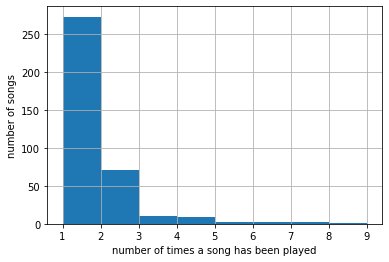

In [181]:
song_count["temperature"].hist(bins=8)
plt.ylabel("number of songs")
plt.xlabel("number of times a song has been played");

In [182]:
ranking1 = data[data["song"].isin(song_count[song_count["temperature"] >= 2].index)]
ranking1.shape[0]

1786

In [183]:
ranking2 = data[data["song"].isin(song_count[song_count["temperature"] >= 3].index)]
ranking1.shape[0]

1786

In [184]:
ranking1.groupby("song").mean()[["mood", "temperature_mood", "humidity_mood"]].sort_values("temperature_mood", ascending=False).head(10)

,mood,temperature_mood,humidity_mood
song,,,
Die Atzen - Disco Pogo,0.049168,0.055049,-1.693703e-02
Nena - 99 Luftballons,0.032051,0.033333,-1.184238e-15
DJ Mico - Kuhbar-Song - Radio Edit,0.033663,0.032894,9.152663e-03
Peter Schilling - Major Tom,0.013982,0.028021,-5.832686e-02
VIZE - Paradise,0.015598,0.027778,-5.000000e-02
Tream - LEBENSLANG - HBz Remix,0.004754,0.022993,-7.809478e-02
Da Wirtshausfranz - Sperma Rosi,0.012131,0.022503,-4.277929e-02
Coone - Superman,0.005950,0.021169,-6.482073e-02
Die Zipfelbuben - Olivia,0.003461,0.020703,-7.400831e-02


In [185]:
ranking2.groupby("song").mean()[["mood", "temperature_mood", "humidity_mood"]].sort_values("temperature_mood", ascending=False).head(10)

,mood,temperature_mood,humidity_mood
song,,,
Die Atzen - Disco Pogo,0.049168,0.055049,-0.016937
DJ Mico - Kuhbar-Song - Radio Edit,0.033663,0.032894,0.009153
Tream - LEBENSLANG - HBz Remix,0.004754,0.022993,-0.078095
Da Wirtshausfranz - Sperma Rosi,0.012131,0.022503,-0.042779
Die Zipfelbuben - Olivia,0.003461,0.020703,-0.074008
R3HAB - 911,0.010040,0.014228,-0.016384
Micha von der Rampe - Partyanimal,0.009876,0.010235,0.000154
Julian Sommer - Dicht im Flieger,0.016136,0.009740,0.030466
Little Sis Nora - Rave In My Garage,0.013114,0.009717,0.016968


In [186]:
ranking = pd.DataFrame()
ranking["song"] = ranking1["song"].unique()
ranking = ranking.set_index("song")

In [187]:
data.columns[-16:-4]

Index(['ventilation_pred2', 'temperature_mood', 'temperature_mood_ven',
       'temperature_mood_0', 'humidity_mood', 'humidity_mood_ven',
       'humidity_mood_0', 'eCO2_mood', 'eCO2_mood_ven', 'eCO2_mood_0',
       'TVOC_mood', 'TVOC_mood_ven'],
      dtype='object')

In [188]:
for measure in data.columns[-16:-4]:
    ranking.loc[ranking1.groupby("song").mean().sort_values(measure, ascending=False).index.values, measure+"_r1"] = range(ranking1["song"].nunique())
    ranking.loc[ranking2.groupby("song").mean().sort_values(measure, ascending=False).index.values, measure+"_r2"] = range(ranking2["song"].nunique())

In [189]:
ranking.columns.values

array(['ventilation_pred2_r1', 'ventilation_pred2_r2',
       'temperature_mood_r1', 'temperature_mood_r2',
       'temperature_mood_ven_r1', 'temperature_mood_ven_r2',
       'temperature_mood_0_r1', 'temperature_mood_0_r2',
       'humidity_mood_r1', 'humidity_mood_r2', 'humidity_mood_ven_r1',
       'humidity_mood_ven_r2', 'humidity_mood_0_r1', 'humidity_mood_0_r2',
       'eCO2_mood_r1', 'eCO2_mood_r2', 'eCO2_mood_ven_r1',
       'eCO2_mood_ven_r2', 'eCO2_mood_0_r1', 'eCO2_mood_0_r2',
       'TVOC_mood_r1', 'TVOC_mood_r2', 'TVOC_mood_ven_r1',
       'TVOC_mood_ven_r2'], dtype=object)

In [190]:
error_matrix1 = pd.DataFrame()
for col1 in ranking.columns[range(0,24,2)]:
    error_list = pd.Series(dtype="float64")
    for col2 in ranking.columns[range(0,24,2)]:
        rank_notna = ranking[(ranking[col1].notna()) & (ranking[col2].notna())]
        try:
            error = mean_squared_error(rank_notna[col1], rank_notna[col2])
        except ValueError:
            error = np.nan
        error_list[col2] = error
    error_matrix1[col1] = error_list       

In [191]:
error_matrix2 = pd.DataFrame()
for col1 in ranking.columns[range(1,24,2)]:
    error_list = pd.Series(dtype="float64")
    for col2 in ranking.columns[range(1,24,2)]:
        rank_notna = ranking[(ranking[col1].notna()) & (ranking[col2].notna())]
        try:
            error = mean_squared_error(rank_notna[col1], rank_notna[col2])
        except ValueError:
            error = np.nan
        error_list[col2] = error
    error_matrix2[col1] = error_list       

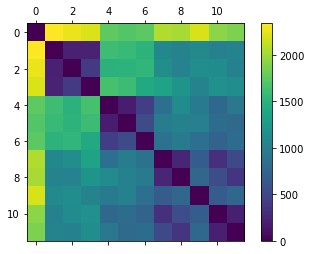

In [192]:
fig, ax = plt.subplots()
cax = ax.matshow(error_matrix1);
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cax);#, cax=cbar_ax)

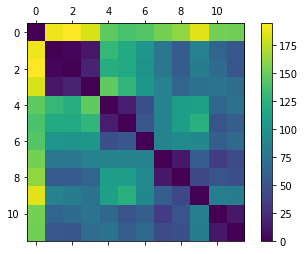

In [193]:
fig, ax = plt.subplots()
cax = ax.matshow(error_matrix2);
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cax);#, cax=cbar_ax)

In [194]:
data["TVOC"].corr(data["eCO2"])

0.9566199018012862

In [195]:
data.tail(1)

,timestamp,temperature,humidity,eCO2,TVOC,inf0,inf1,inf2,inf3,inf4,...,humidity_mood_0,eCO2_mood,eCO2_mood_ven,eCO2_mood_0,TVOC_mood,TVOC_mood_ven,TVOC_mood_0,mood,mood_ven,mood_0
7277,2022-07-31 21:21:44.338253,NaN,NaN,400.0,0.0,26.5,25.75,26.0,25.25,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
data["num_people"].notna().sum()/6/60

4.097222222222222